# **Trabajo Práctico 1 : Propiedades en Venta**

El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

In [ ]:
%matplotlib inline

# Imports
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats as st

In [ ]:
# Load Data
properati_df = pd.read_csv("https://raw.githubusercontent.com/FranFiuba/7506R-2C2022-GRUPO02/main/Datasets/properati_argentina_2021.csv")
properati_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

## **1. Análisis Exploratorio y Preprocesamiento de Datos**

El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD). Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

#### Filtro los datos

Chequeo que no haya tipos de propiedades mal parseados/con errores

In [ ]:
properati_df['property_type'].unique()

array(['Casa', 'PH', 'Departamento', 'Lote', 'Depósito', 'Otro',
       'Local comercial', 'Oficina', 'Casa de campo', 'Cochera'],
      dtype=object)

Chequeo que no haya ciudades ('place_l2') mal parseados

In [ ]:
properati_df['place_l2'].unique()

array(['Neuquén', 'Montevideo', 'Entre Ríos', 'Maldonado',
       'Bs.As. G.B.A. Zona Norte', 'Córdoba', 'Mendoza',
       'Capital Federal', 'Canelones', 'Misiones', 'Santa Fe', 'Tucumán',
       'Bs.As. G.B.A. Zona Oeste', 'Salta', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Interior', 'San Juan', 'Michigan',
       'Buenos Aires Costa Atlántica', 'Chubut', 'Río Negro',
       'Corrientes', 'La Pampa', 'Colonia', 'San Luis', 'Jujuy',
       'Florida', 'Tierra Del Fuego', 'Santiago Del Estero',
       'Santa Catarina', 'Chaco', 'Rocha', 'Rio Grande do Norte',
       'Formosa', 'Catamarca', 'Santa Cruz', 'Rio de Janeiro',
       'São Paulo', 'Maryland', 'Miami', 'La Rioja', 'Pennsylvania',
       'California'], dtype=object)

Chequeo que no haya tipos de operación mal parseados

In [ ]:
properati_df['operation'].unique()

array(['Venta', 'Alquiler', 'Alquiler temporal'], dtype=object)

Chequeo que no haya tipos de moneda mal parseados

In [ ]:
properati_df['property_currency'].unique()

array([nan, 'USD', 'UYU', 'ARS', 'PEN', 'COP'], dtype=object)

Se omitirá el analisis de los valores nulos de 'property_currency'

In [ ]:
# Filtro para seleccionar las propiedades que son del tipo Casa, PH o Departamento
propery_type_filter = properati_df.property_type.isin(['Casa', 'PH', 'Departamento'])

# Filtro para seleccionar las propiedades localizadas en Capital federal
place_is_caba = properati_df.place_l2 == 'Capital Federal'

# Filtro para seleccionar las propiedades que tienen por operacion la Venta
operation_is_venta = properati_df.operation == 'Venta'

# Filtro para seleccionar las propiedades en dolares
currency_is_usd = properati_df.property_currency == 'USD'

# Aplico los filtros sobre el dataset original
properati_df = properati_df.loc[currency_is_usd & operation_is_venta & place_is_caba & propery_type_filter]

Elimino las columnas que no interesan

 -  'place_l5' y 'place_l6' tienen todos sus valores en null
 -  'place_l2', 'operation' y 'property_currency' tienen un solo valor
 -  'id' y 'property_title' no aportan ninguna informacion que interese en este analisis

Si bien 'place_l4' tiene muchos valores en null, puede ser util para subdividir barrios

In [ ]:
columns_drop = ['place_l5', 'place_l6', 'place_l2', 'operation', 'property_currency', 'id', 'property_title']
columns_rename = {'place_l3':'district', 'place_l4':'subdistrict', 'property_rooms':'rooms', 'property_bedrooms':'bedrooms',\
                  'property_surface_total':'surface_total', 'property_surface_covered':'surface_covered', 'property_price':'price'}
properati_df.drop(columns=columns_drop, inplace=True)
properati_df.rename(columns=columns_rename, inplace=True)
properati_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Separacion entre set de entrenamiento y de test

In [ ]:
x_cols = properati_df.columns.tolist()
x_cols.remove('price')

x_ds = properati_df[x_cols].copy()
y_ds = properati_df['price'].copy()

properati_train, properati_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.2, random_state=2)

# creamos un data frame que vincule x_train y y_train para el analisis exploratorio 
properati_train['price'] = y_train

# tambien creo un dataframe con los datos de test para pasar cambios
properati_test['price'] = y_test

print("Registros de train: ", properati_train.shape[0])
print("Registros de test: ", properati_test.shape[0])

Registros de train:  75399
Registros de test:  18850


### **a) Exploración Inicial**

#### **Analisis General**

Obtenemos una mirada general del dataset

In [ ]:
properati_train.shape

(75399, 13)

In [ ]:
properati_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75399 entries, 52019 to 89256
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_date       75399 non-null  object 
 1   end_date         75399 non-null  object 
 2   created_on       75399 non-null  object 
 3   latitud          72416 non-null  float64
 4   longitud         72416 non-null  float64
 5   district         75053 non-null  object 
 6   subdistrict      2910 non-null   object 
 7   property_type    75399 non-null  object 
 8   rooms            74559 non-null  float64
 9   bedrooms         66550 non-null  float64
 10  surface_total    71515 non-null  float64
 11  surface_covered  72759 non-null  float64
 12  price            75399 non-null  float64
dtypes: float64(7), object(6)
memory usage: 8.1+ MB


In [ ]:
properati_train.describe()

,latitud,longitud,rooms,bedrooms,surface_total,surface_covered,price
count,72416.000000,72416.000000,74559.000000,66550.000000,71515.00000,72759.000000,7.539900e+04
mean,-34.591125,-58.450693,2.822798,2.015567,112.53916,90.110213,2.273315e+05
std,0.189522,0.304372,1.429959,1.133740,1088.20166,1106.636675,3.256379e+05
min,-53.788624,-71.439510,1.000000,-1.000000,10.00000,1.000000,5.000000e+03
25%,-34.615979,-58.466523,2.000000,1.000000,45.00000,40.000000,9.500000e+04
50%,-34.595749,-58.439042,3.000000,2.000000,65.00000,57.000000,1.440000e+05
75%,-34.577395,-58.408935,4.000000,3.000000,105.00000,89.000000,2.350000e+05
max,-24.219827,-54.133330,40.000000,70.000000,137000.00000,217000.000000,2.140000e+07


Para cada variable cuantitativa vamos a obtener ya obtuvimos el promedio, q1 (25%) y q3(75%) nos faltan la moda y la mediana.

In [ ]:
quantitative = ["latitud",	"longitud",	"rooms",	"bedrooms",	"surface_total", "surface_covered",	"price"]

for col in quantitative:
  median = np.median(properati_train.loc[properati_train[col].notna(), col])
  mode = st.mode(properati_train.loc[properati_train[col].notna(), col]).mode[0]
  print(f"{col}: Mode: {mode} - Median: {median}")

latitud: Mode: -34.5412501 - Median: -34.5957487
longitud: Mode: -58.4729664 - Median: -58.439042400000005
rooms: Mode: 3.0 - Median: 3.0
bedrooms: Mode: 1.0 - Median: 2.0
surface_total: Mode: 50.0 - Median: 65.0
surface_covered: Mode: 40.0 - Median: 57.0
price: Mode: 110000.0 - Median: 144000.0


#### **Fechas**

Analizamos la cantidad de valores posibles y la frecuencia de cada uno.



In [ ]:
column_date = ['start_date', 'created_on', 'end_date']

for date in column_date:
  print(f"Distinct {date}: {properati_train[date].nunique()}")

Distinct start_date: 365
Distinct created_on: 365
Distinct end_date: 603


In [ ]:
for date in column_date:
  print(f"{date}")
  print(f"{properati_train[date].value_counts().head()}")

start_date
2021-12-16    3734
2021-02-13    1724
2021-11-03     837
2021-08-03     677
2021-04-30     663
Name: start_date, dtype: int64
created_on
2021-12-16    3734
2021-02-13    1724
2021-11-03     837
2021-08-03     677
2021-04-30     663
Name: created_on, dtype: int64
end_date
2021-06-05    10230
2022-01-27     7434
2022-02-09     6103
9999-12-31     4011
2021-03-01     1508
Name: end_date, dtype: int64


In [ ]:
dates = properati_train.loc[:, ['start_date', 'created_on', 'end_date']].copy()

for column in dates.columns:
    dates[column] = pd.to_datetime(dates[column], yearfirst=True, errors='coerce')

dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75399 entries, 52019 to 89256
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  75399 non-null  datetime64[ns]
 1   created_on  75399 non-null  datetime64[ns]
 2   end_date    71388 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 2.3 MB


In [ ]:
properati_train.loc[dates['end_date'].isna(), 'end_date'].unique()

array(['9999-12-31'], dtype=object)

Vemos que el único valor que nos da una fecha nula es el 31 de diciembre de 9999.

In [ ]:
for column in dates.columns:
    properati_train[column] = dates[column]

properati_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75399 entries, 52019 to 89256
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       75399 non-null  datetime64[ns]
 1   end_date         71388 non-null  datetime64[ns]
 2   created_on       75399 non-null  datetime64[ns]
 3   latitud          72416 non-null  float64       
 4   longitud         72416 non-null  float64       
 5   district         75053 non-null  object        
 6   subdistrict      2910 non-null   object        
 7   property_type    75399 non-null  object        
 8   rooms            74559 non-null  float64       
 9   bedrooms         66550 non-null  float64       
 10  surface_total    71515 non-null  float64       
 11  surface_covered  72759 non-null  float64       
 12  price            75399 non-null  float64       
dtypes: datetime64[ns](3), float64(7), object(3)
memory usage: 8.1+ MB


Vemos que el único valor que nos da una fecha nula es el 31 de diciembre de 9999.

In [ ]:
print("Primer publicación: ", properati_train['start_date'].min())
print("Ultima publicación: ", properati_train['start_date'].max())

Primer publicación:  2021-01-01 00:00:00
Ultima publicación:  2021-12-31 00:00:00


In [ ]:
dates_differ = properati_train['start_date'] != properati_train['created_on']
dates_differ.value_counts()

False    75399
dtype: int64

Segun la documentación de Properati, 'start_date' es la fecha de inicio de la version actual del aviso, y 'created_on' es la fecha de inicio de la primer version del aviso. Como no difieren, se puede deducir que todas estas publicaciones son su primer version.

Por otro lado, 'created_on' es un dato irrelevante para este estudio ya que no se tiene informacion sobre el precio al que se vendia la propiedad originalmente. Saber cuando se puso en venta por primera vez solamente no tiene mucha utilidad.

In [ ]:
print("Primer venta: ", properati_train['end_date'].min())
print("Ultima venta: ", properati_train['end_date'].max())

Primer venta:  2021-01-02 00:00:00
Ultima venta:  2022-09-19 00:00:00


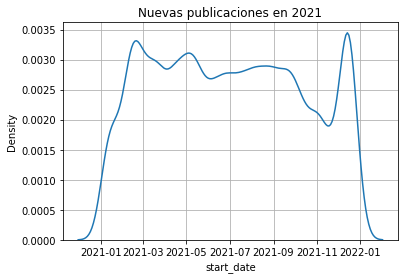

In [ ]:
plt.grid(True)
sns.kdeplot(data=properati_train['start_date'])
plt.title("Nuevas publicaciones en 2021")
plt.show()

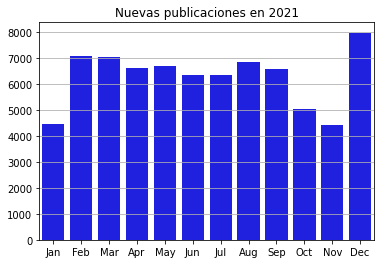

In [ ]:
monthly_new = properati_train['start_date'].dt.strftime('%b').value_counts()
order_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

plt.grid(True)
sns.barplot(x=monthly_new.index, y=monthly_new.array, color="blue", order=order_months)
plt.title("Nuevas publicaciones en 2021")
plt.show()

Las nuevas publicaciones se mantuvieron de forma uniforme durante casi todo el año. Hubo una caida de nuevas publicaciones en enero, octubre y noviembre, luego alcanzaron un pico, el maximo en el año, en diciembre.

Podria tambien analizar las ventas durante el año mediante la variable 'end_date' pero estas solo serian las ventas de propiedades publicadas en 2021.

#### **Precio**

In [ ]:
print("Precio minimo: ", properati_train['price'].min())
print("Precio maximo: ", properati_train['price'].max())

Precio minimo:  5000.0
Precio maximo:  21400000.0


Hay mucha varianza de precios asi que para poder visualizar los datos uso el logaritmo

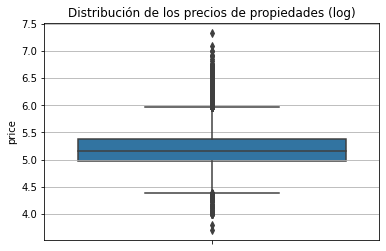

In [ ]:
plt.grid(True)
price_log = np.log10(properati_train['price'])
sns.boxplot(y=price_log)
plt.title("Distribución de los precios de propiedades (log)")
plt.show()

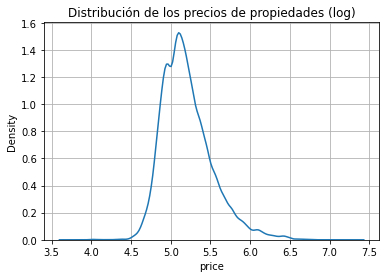

In [ ]:
plt.grid(True)
sns.kdeplot(data=price_log)
plt.title("Distribución de los precios de propiedades (log)")
plt.show()

In [ ]:
mean = round(properati_train['price'].mean())
q1 = round(np.nanpercentile(properati_train['price'], 25))
median = round(properati_train['price'].median())
q3 = round(np.nanpercentile(properati_train['price'], 75))
mode = round(properati_train['price'].mode()[0])

print(f"Precio promedio: ${mean:,.0f}")
print(f"Primer cuartil: ${q1:,.0f}")
print(f"Mediana: ${median:,.0f}")
print(f"Tercer cuartil: ${q3:,.0f}")
print(f"Moda: ${mode:,.0f}")

Precio promedio: $227,332
Primer cuartil: $95,000
Mediana: $144,000
Tercer cuartil: $235,000
Moda: $110,000


#### **Barrios**

In [ ]:
print("Cantidad de barrios: ", properati_train['district'].unique().size)
print("Cantidad de sub-barrios: ", properati_train['subdistrict'].unique().size)

Cantidad de barrios:  58
Cantidad de sub-barrios:  5


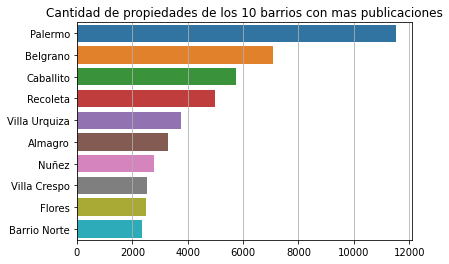

In [ ]:
districts = properati_train['district'].value_counts()
plt.grid(True)
sns.barplot(x=districts.array[0:10], y=districts.index[0:10], orient="h")
plt.title("Cantidad de propiedades de los 10 barrios con mas publicaciones")
plt.show()

In [ ]:
properati_train['subdistrict'].value_counts()

Palermo Hollywood    1245
Palermo Chico         889
Palermo Soho          639
Palermo Viejo         137
Name: subdistrict, dtype: int64

#### **Tipo de propiedad**

In [ ]:
properati_train['property_type'].value_counts()

Departamento    64679
PH               7406
Casa             3314
Name: property_type, dtype: int64

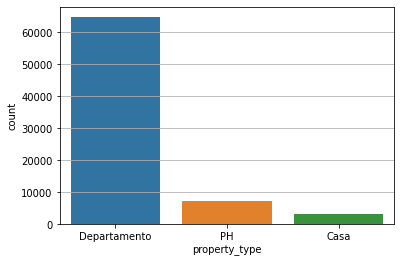

In [ ]:
plt.grid(True)
sns.countplot(x='property_type', data=properati_train)
plt.show()

Vemos que el conjunto no está balanceado. Las propiedades de tipo 'Departamento' estan mucho mas representadas que 'PH' o 'Casa'

#### **Ambientes**

In [ ]:
print("Max ambientes: ", properati_train['rooms'].max())
print("Min ambientes: ", properati_train['rooms'].min())

Max ambientes:  40.0
Min ambientes:  1.0


In [ ]:
print("Max dormitorios: ", properati_train['bedrooms'].max())
print("Min dormitorios: ", properati_train['bedrooms'].min())

Max dormitorios:  70.0
Min dormitorios:  -1.0


Segun la documentacion de Properati sobre este dataset, la variable 'rooms' representa los ambientes de una propiedad, util en Argentina, mientras que 'bedrooms' representa la cantidad de dormitorios, que se usa en otros paises. Ya que estamos trabajando solo con propiedades en Argentina podriamos quedarnos solo con la variable 'rooms'.

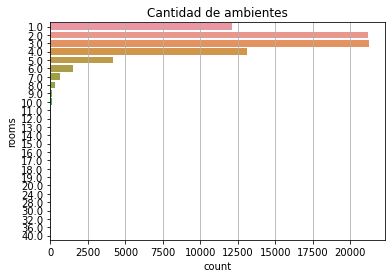

In [ ]:
plt.grid(True)
sns.countplot(data=properati_train, y='rooms', orient="h")
plt.title("Cantidad de ambientes")
plt.show()

Como era de esperarse, la mayor parte de las propiedades tienen menos de 10 ambientes.

In [ ]:
mean = round(properati_train['rooms'].mean())
q1 = round(np.nanpercentile(properati_train['rooms'], 25))
median = round(properati_train['rooms'].median())
q3 = round(np.nanpercentile(properati_train['rooms'], 75))
mode = round(properati_train['rooms'].mode()[0])

print(f"Ambientes promedio: {mean:,.0f} ambientes")
print(f"Primer cuartil: {q1:,.0f} ambientes")
print(f"Mediana: {median:,.0f} ambientes")
print(f"Tercer cuartil: {q3:,.0f} ambientes")
print(f"Moda: {mode:,.0f} ambientes")

Ambientes promedio: 3 ambientes
Primer cuartil: 2 ambientes
Mediana: 3 ambientes
Tercer cuartil: 4 ambientes
Moda: 3 ambientes


#### **Superficie**

In [ ]:
print(f"Superficie total maxima: {properati_train['surface_total'].max():,.0f} m2")
print(f"Superficie total minima: {properati_train['surface_total'].min():,.0f} m2")

Superficie total maxima: 137,000 m2
Superficie total minima: 10 m2


Como hay tanta visualizar, voy a tener que usar el logaritmo para visualizar la distribucion.

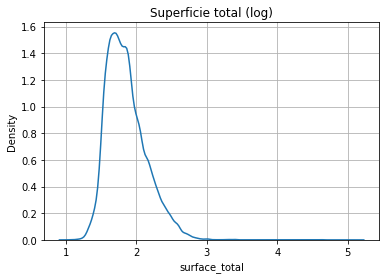

In [ ]:
plt.grid(True)
sns.kdeplot(data=np.log10(properati_train['surface_total']))
plt.title("Superficie total (log)")
plt.show()

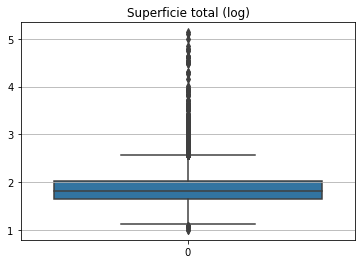

In [ ]:
plt.grid(True)
sns.boxplot(data=np.log10(properati_train['surface_total']))
plt.title("Superficie total (log)")
plt.show()

In [ ]:
mean = round(properati_train['surface_total'].mean())
q1 = round(np.nanpercentile(properati_train['surface_total'], 25))
median = round(properati_train['surface_total'].median())
q3 = round(np.nanpercentile(properati_train['surface_total'], 75))
mode = round(properati_train['surface_total'].mode()[0])

print(f"Superficie promedio: {mean:,.0f} m2")
print(f"Primer cuartil: {q1:,.0f} m2")
print(f"Mediana: {median:,.0f} m2")
print(f"Tercer cuartil: {q3:,.0f} m2")
print(f"Moda: {mode:,.0f} m2")

Superficie promedio: 113 m2
Primer cuartil: 45 m2
Mediana: 65 m2
Tercer cuartil: 105 m2
Moda: 50 m2


Si bien la documentacion no lo especifica, vale la pena mencionar que, analizando la variable, es facil ver que se refiere a la superficie de la propiedad y no la superficie del terreno.

In [ ]:
print(f"Superficie cubierta maxima: {properati_train['surface_covered'].max():,.0f} m2")
print(f"Superficie cubierta minima: {properati_train['surface_covered'].min():,.0f} m2")

Superficie cubierta maxima: 217,000 m2
Superficie cubierta minima: 1 m2


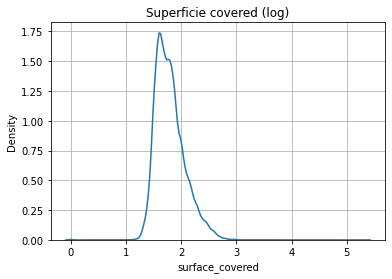

In [ ]:
plt.grid(True)
sns.kdeplot(data=np.log10(properati_train['surface_covered']))
plt.title("Superficie covered (log)")
plt.show()

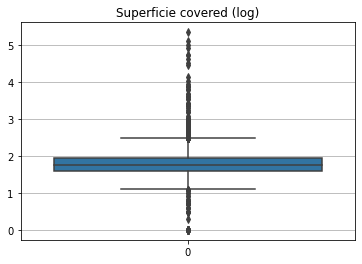

In [ ]:
plt.grid(True)
sns.boxplot(data=np.log10(properati_train['surface_covered']))
plt.title("Superficie covered (log)")
plt.show()

In [ ]:
mean = round(properati_train['surface_covered'].mean())
q1 = round(np.nanpercentile(properati_train['surface_covered'], 25))
median = round(properati_train['surface_covered'].median())
q3 = round(np.nanpercentile(properati_train['surface_covered'], 75))
mode = round(properati_train['surface_covered'].mode()[0])

print(f"Superficie cubierta promedio: {mean:,.0f} m2")
print(f"Primer cuartil: {q1:,.0f} m2")
print(f"Mediana: {median:,.0f} m2")
print(f"Tercer cuartil: {q3:,.0f} m2")
print(f"Moda: {mode:,.0f} m2")

Superficie cubierta promedio: 90 m2
Primer cuartil: 40 m2
Mediana: 57 m2
Tercer cuartil: 89 m2
Moda: 40 m2


#### **Correlaciones**

In [ ]:
num_columns = ['rooms', 'bedrooms', 'surface_total', 'surface_covered', 'price']
properati_train.loc[:, num_columns].corr().style.background_gradient(cmap='coolwarm')

,rooms,bedrooms,surface_total,surface_covered,price
rooms,1.000000,0.867790,0.062585,0.069341,0.485533
bedrooms,0.867790,1.000000,0.063116,0.068169,0.424579
surface_total,0.062585,0.063116,1.000000,0.607612,0.082295
surface_covered,0.069341,0.068169,0.607612,1.000000,0.051316
price,0.485533,0.424579,0.082295,0.051316,1.000000


Observaciones sobre la matriz de correlacion:


*   'rooms' y 'bedrooms' tienen una correlacion bastante alta. Teniendo en cuenta el analisis que se hizo en ambientes, es todavia mas razonable eliminar la columna de 'bedrooms'
*   La correlacion entre 'surface_total' y 'surface_covered' es bastante alta pero no tanto como uno esperaria tal vez.
*   Ninguna variable por si sola tiene una correlacion muy alta con el precio. La mas alta es la de 'rooms' que no llega al 0.5





##### Relacion precio-fechas

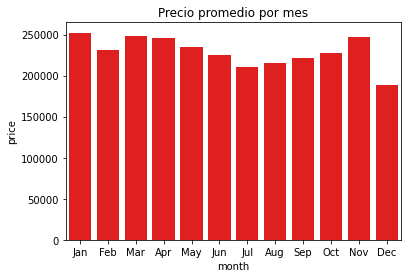

In [ ]:
order_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

properati_train['month'] = dates['start_date'].dt.strftime('%b')
price_by_month = properati_train.groupby('month', as_index=False)['price'].mean()

plt.title('Precio promedio por mes')

sns.barplot(x="month", y="price", data=price_by_month ,color="red", order=order_months)

plt.show()

Los precios parecen ser bastante uniformes respecto al mes, salvo por diciembre donde huba una caida de mas del 20% en el precio promedio de las propiedades publicadas. Esto podria tener que ver con el hecho de que diciembre tambien fue el mes en el que mas nuevas publicaciones hubo.

In [ ]:
properati_train['price'].corr((properati_train['end_date'] - properati_train['end_date'].min()).apply(lambda x: x.days))

-0.02291437798041429

Vemos que la correlacion entre el precio de una propiedad y la fecha en la que se vendio (vista como los dias desde una fecha fija), es muy baja.

In [ ]:
properati_train['price'].corr((properati_train['start_date'] - properati_train['start_date'].min()).apply(lambda x: x.days))

-0.03881283755931589

In [ ]:
properati_train['price'].corr((properati_train['created_on'] - properati_train['created_on'].min()).apply(lambda x: x.days))

-0.03881283755931589

Vemos que la correlacion entre el precio y la fecha de creacion y comienzo es tambien muy baja

##### Relacion precio-coordenadas

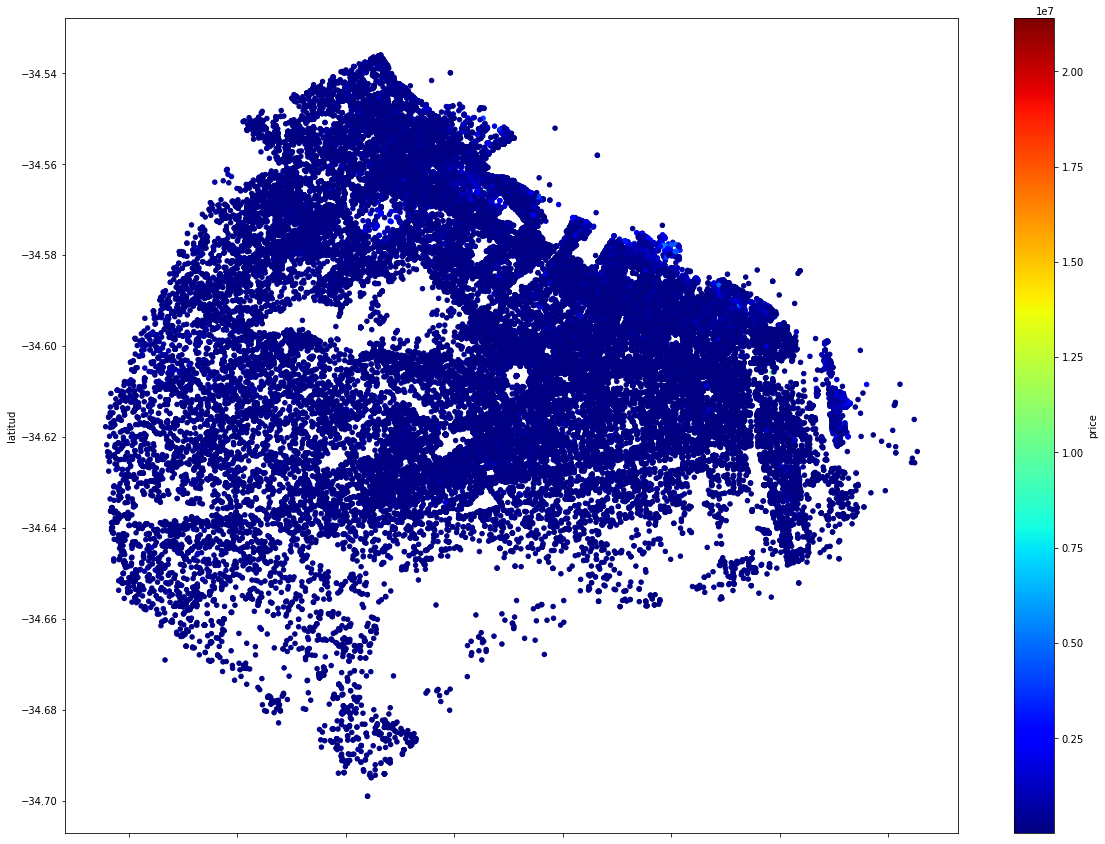

In [ ]:
# Aproximadamente las coordenadas entre las que se encuentra Buenos Aires
latitud_filter = (properati_train['latitud'] < -34.5) & (properati_train['latitud'] > -34.71)
longitud_filter = (properati_train['longitud'] < -58.33) & (properati_train['longitud'] > -58.54)
properati_train[latitud_filter & longitud_filter].plot(kind="scatter", x="longitud", y="latitud", c="price", figsize=(20,15),cmap=plt.get_cmap("jet"), colorbar=True)
plt.show()

Ya que la varianza de precios es tan grande, no se llegan a apreciar zonas de precios. Tambien hubo que aplicar un filtro para coordenadas de capital, esto se tratara en la seccion de datos faltantes.

##### Relacion precio-barrio

In [ ]:
price_by_district = properati_train.groupby('district', as_index=False)['price'].mean().sort_values(by=['price'], ascending=False)
price_by_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 34 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   district  57 non-null     object 
 1   price     57 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


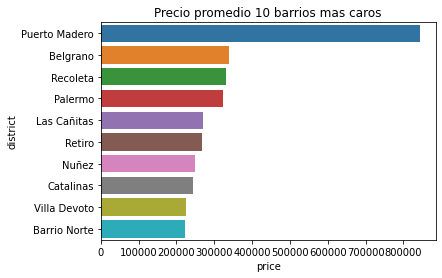

In [ ]:
plt.title('Precio promedio 10 barrios mas caros')

sns.barplot(x=price_by_district.head(10)['price'], y=price_by_district.head(10)['district'], orient="h")

plt.show()

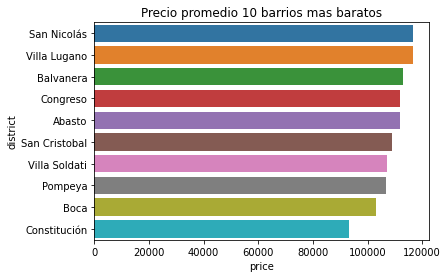

In [ ]:
plt.title('Precio promedio 10 barrios mas baratos')

sns.barplot(x=price_by_district.tail(10)['price'], y=price_by_district.tail(10)['district'], orient="h")

plt.show()

Si bien la diferencia de precios es bastante uniforme para todos los barrios, Puerto Madero es excepcionalmente caro.

##### Relacion precio-tipo de propiedad

In [ ]:
properati_train.groupby('property_type')['price'].agg([np.mean, np.median])

,mean,median
property_type,,
Casa,468528.950211,327500.0
Departamento,220905.670991,137000.0
PH,175520.946395,153000.0


##### Relacion ambientes-dormitorios

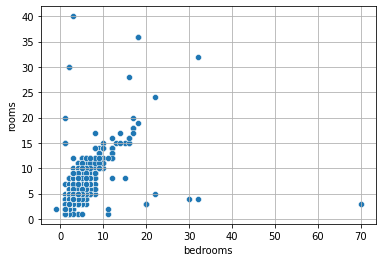

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train, x='bedrooms', y='rooms')

##### Relacion superficie total - superficie cubierta

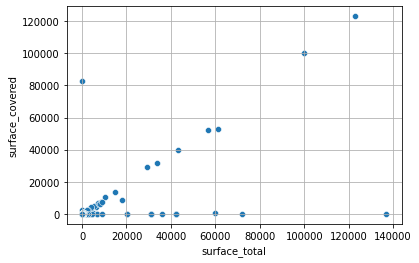

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train, x='surface_total', y='surface_covered')

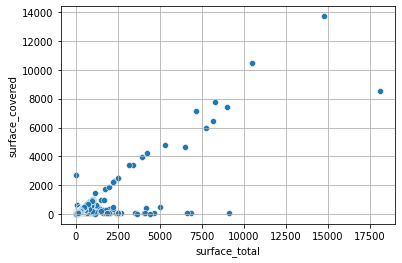

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train[(properati_train['surface_total'] < 20000) & (properati_train['surface_covered'] < 20000)], x='surface_total', y='surface_covered')

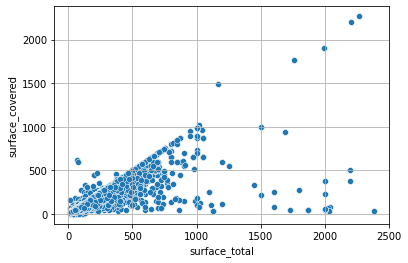

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train[(properati_train['surface_total'] < 2500) & (properati_train['surface_covered'] < 2500)], x='surface_total', y='surface_covered')

### **b) Datos Faltantes**

#### **Fechas faltantes**

In [ ]:
print("Fechas nulas en train")
print(" 'start_date' nulos: ", properati_train['start_date'].isna().sum())
print(" 'end_date' nulos: ", properati_train['end_date'].isna().sum())

Fechas nulas en train
 'start_date' nulos:  0
 'end_date' nulos:  0


In [ ]:
properati_train['end_date'].isna().sum() / properati_train.shape[0] * 100

0.0

Una forma de interpretar las fechas de venta nulas es que la propiedad todavia no se vendio. Es decir, el 5,32% de las propiedades del set todavia no se vendieron.

En cualquier caso, ya que la correlacion entre el precio y la fecha de venta es baja como ya se vio, se eliminara esta variable mas adelante ya que no aporta suficiente informacion.

#### **Precios faltantes**

In [ ]:
properati_train['price'].isna().sum()

0

No solamente no hay campos nulos en la variable precio, si no que como ya se vio en el analisis previo, tampoco hay valores que no tengan sentido (por ejemplo valores negativos). Se deja el analisis de outliers para mas adelante

#### **Barrios faltantes**

In [ ]:
print(properati_train['district'].isna().sum())
print(properati_train['district'].isna().sum() / properati_train.shape[0] * 100)

346
0.45889202774572607


Hay barrios con valores nulos. Solo representan un 0,46% de los registros. Como son pocos se los va a eliminar.

In [ ]:
def merge_distric_with_subdistric(df): 
  pd.set_option('mode.chained_assignment', None)
  df.loc[:, 'district'].where(df['subdistrict'].isna(), df['subdistrict'], inplace=True)
  pd.reset_option("mode.chained_assignment")

In [ ]:
def apply_missing_district_transformation(df):
  df.dropna(subset=['district'], inplace=True)

In [ ]:
merge_distric_with_subdistric(properati_train)
apply_missing_district_transformation(properati_train)
print(properati_train['district'].isna().sum())

0


In [ ]:
properati_train['subdistrict'].isna().sum()

72143

Los valores de sub-barrio solamente son validos en algunos casos, en Palermo para ser especifico. Mas adelante se va a usar una transformacion para juntar barrio y sub-barrio en una sola variable.

#### **Tipo de propiedades faltantes**

In [ ]:
properati_train['property_type'].isna().sum()

0

#### **Ambientes faltantes**

In [ ]:
print(properati_train['rooms'].isna().sum())
print(properati_train['rooms'].isna().sum() / properati_train.shape[0] * 100)

773
1.0299388432174597


In [ ]:
(properati_train['rooms'].isna() & properati_train['bedrooms'].notna()).sum()

428

Como se vio anteriormenta, la correlacion entre ambientes y dormitorios es muy fuerte y es casi 1 a 1. Voy a usar los dormitorios para completar ambientes.

In [ ]:
def apply_missing_rooms_transformation(df):
  df.loc[:, 'rooms'].fillna(value=df['bedrooms'], inplace=True)
  df.dropna(subset=['rooms'], inplace=True)

In [ ]:
apply_missing_rooms_transformation(properati_train)
properati_train['rooms'].isna().sum()

0

#### **Coordenadas faltantes**

In [ ]:
print(properati_train['latitud'].isna().sum())
print(properati_train['longitud'].isna().sum())
print((properati_train['latitud'].isna() & properati_train['longitud'].isna()).sum())

2793
2793
2793


In [ ]:
latitud_filter = (properati_train['latitud'] >= -34.5) | (properati_train['latitud'] < -34.71)
longitud_filter = (properati_train['longitud'] >= -58.33) | (properati_train['longitud'] < -58.54)
bad_coords_cnt = properati_train[latitud_filter & longitud_filter].shape[0]
print("Registros con coordenadas fuera de la capital: ", bad_coords_cnt)

Registros con coordenadas fuera de la capital:  0


En el algun filtrado anterior tambien se filtraron las coordenadas invalidas. Igual voy a definir una transformacion en general para usar tambien en el set de test.

In [ ]:
def apply_coords_transformation(df):
  df.dropna(subset=['latitud', 'longitud'], inplace=True)
  latitud_filter = (df['latitud'] >= -34.5) | (df['latitud'] < -34.71)
  longitud_filter = (df['longitud'] >= -58.33) | (df['longitud'] < -58.54)
  index = df.index[latitud_filter & longitud_filter]
  df.drop(index=index, inplace=True)

In [ ]:
properati_train.shape[0]

74708

In [ ]:
apply_coords_transformation(properati_train)
properati_train.shape[0]

71915

#### **Superficie faltante**

In [ ]:
print("Registros con superficie total nula: ", properati_train['surface_total'].isna().sum())
print(properati_train['surface_total'].isna().sum() / properati_train.shape[0] * 100, "%")

Registros con superficie total nula:  3602
5.008690815546131 %


In [ ]:
print("Registros con superficie cubierta nula: ", properati_train['surface_covered'].isna().sum())
print(properati_train['surface_covered'].isna().sum() / properati_train.shape[0] * 100, "%")

Registros con superficie cubierta nula:  2476
3.442953486755197 %


In [ ]:
cnt = (properati_train['surface_total'].isna() & properati_train['surface_covered'].isna()).sum()
print("Registros sin informacion sobre la superficie: ", cnt)
print(cnt / properati_train.shape[0] * 100, "%")

Registros sin informacion sobre la superficie:  0
0.0 %


Habiendo visto que la correlacion entre estas 2 variables es bastante alta, y guiandome por los graficos voy a usar un regresion lineal para completar valores nulos.

Donde haya un valor de superficie y el otra sea nulo, uso regresion lineal para completar. Elimino los registros donde ambos son nulos.

In [ ]:
from sklearn.linear_model import LinearRegression

def apply_missing_surface_transformation(df):
  df_aux = df.dropna(subset=['surface_total', 'surface_covered'])
  surface_total = df_aux['surface_total'].copy().values.reshape(-1, 1)
  surface_covered = df_aux['surface_covered'].copy().values.reshape(-1, 1)

  surface_total_predictor = LinearRegression()
  surface_total_predictor.fit(surface_covered, surface_total)
  a1 = round(surface_total_predictor.coef_[0][0],2)
  a0 = round(surface_total_predictor.intercept_[0],2)
  df.loc[:, 'surface_total'].fillna(value=(a1*df['surface_covered']+a0), inplace=True)

  surface_covered_predictor = LinearRegression()
  surface_covered_predictor.fit(surface_total, surface_covered)
  a1 = round(surface_covered_predictor.coef_[0][0],2)
  a0 = round(surface_covered_predictor.intercept_[0],2)
  df.loc[:, 'surface_covered'].fillna(value=(a1*df['surface_total']+a0), inplace=True)

  df.dropna(subset=['surface_total', 'surface_covered'], inplace=True)

In [ ]:
apply_missing_surface_transformation(properati_train)

print("Registros con superficie total nula: ", properati_train['surface_total'].isna().sum())
print("Registros con superficie cubierta nula: ", properati_train['surface_covered'].isna().sum())

Registros con superficie total nula:  0
Registros con superficie cubierta nula:  0


#### **Estado final datos faltantes**

In [ ]:
properati_train.isna().sum()

start_date             0
end_date               0
created_on             0
latitud                0
longitud               0
district               0
subdistrict        69367
property_type          0
rooms                  0
bedrooms            8098
surface_total          0
surface_covered        0
price                  0
dtype: int64

In [ ]:
properati_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71915 entries, 52019 to 89256
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_date       71915 non-null  object 
 1   end_date         71915 non-null  object 
 2   created_on       71915 non-null  object 
 3   latitud          71915 non-null  float64
 4   longitud         71915 non-null  float64
 5   district         71915 non-null  object 
 6   subdistrict      2548 non-null   object 
 7   property_type    71915 non-null  object 
 8   rooms            71915 non-null  float64
 9   bedrooms         63817 non-null  float64
 10  surface_total    71915 non-null  float64
 11  surface_covered  71915 non-null  float64
 12  price            71915 non-null  float64
dtypes: float64(7), object(6)
memory usage: 7.7+ MB


Los datos faltantes que quedan se van a corregir mas adelante mediante otras transformaciones.

### **c) Valores Atipicos** - maso menos completo. Faltarian algunas justificaciones

Segun varias notas el precio maximo por m2 de la ciudad de buenos aires se encuentra en puerto madero y es menor a los 6000 dolares y el mas barato en villa soldati y es mayor a los 700 dolares. Vamos a crer un filtro con una cota superior a los 6000 usd/m2 y una cota inferior de 500 usd/m2.

[Ranking de precios en la ciudad de Buenos Aires](https://eleconomista.com.ar/economia/el-ranking-precios-ciudad-buenos-aires-barrios-mas-caros-mas-economicos-alquilar-n51104#:~:text=Los%20barrios%20de%20Puerto%20Madero,costos%20de%201.141%20d%C3%B3lares%2Fm2%2C)


[Estaditicas precios Caba](https://mudafy.com.ar/d/valor-metro-cuadrado-en-caba-por-barrio#:~:text=El%20barrio%20con%20el%20precio,m2%20y%20USD%201.213%2Fm2.)

In [ ]:
def filtro_precio_m2(df):
  upper_bound = 6000
  lower_bound = 500
  pmx2 = df.price / df.surface_total
  return df[(pmx2 < upper_bound) & (pmx2 > lower_bound)]

In [ ]:
# Funciona pero consume mucho. Con los departamentos hace que colab explote
def get_mahalanobis(df):
  columns = ['price', 'surface_total', 'surface_covered', 'rooms']
  means = np.mean(df[columns])
  diff = df[columns] - means
  cov = df[columns].cov().values
  inv_cov = np.linalg.inv(cov)

  mahalanobis = np.dot(np.dot(diff, inv_cov), diff.T)
  return mahalanobis.diagonal()

In [ ]:
def drop_outliers_by_property_type(df, property_type):
  subset = df.loc[df['property_type'] == property_type, :]
  mahal = get_mahalanobis(subset)
  q1 = np.nanpercentile(mahal, 25)
  q3 = np.nanpercentile(mahal, 75)
  iqr = q3 - q1
  upper_bound = q3 + 3 * iqr
  index = subset.index[mahal > upper_bound]
  df.drop(index=index, inplace=True)

#### **Casas y PHs**

In [ ]:
properati_train.shape[0]

71915

In [ ]:
drop_outliers_by_property_type(properati_train, 'Casa')
properati_train.shape[0]

71643

In [ ]:
drop_outliers_by_property_type(properati_train, 'PH')
properati_train.shape[0]

71215

#### **Departamentos**

La cantidad de departamentos es mucha como para usar la distancia de mahalanobis

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
x = properati_train.loc[properati_train['property_type'] == 'Departamento', ['price', 'surface_total', 'surface_covered', 'rooms']].values
lofc = LocalOutlierFactor(n_neighbors=20)
preds = lofc.fit_predict(x)
scores = lofc.negative_outlier_factor_
scores.size

61586

In [ ]:
q1 = np.nanpercentile(scores, 25)
q3 = np.nanpercentile(scores, 75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
pd.Series(scores < lower_bound).value_counts()

False    54531
True      7055
dtype: int64

In [ ]:
outliers = properati_train.loc[properati_train['property_type'] == 'Departamento', :]
outliers = outliers.loc[scores < lower_bound, :]
outliers.shape[0]

7055

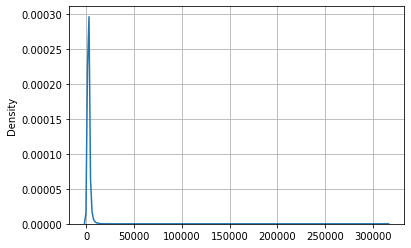

In [ ]:
plt.grid(True)
sns.kdeplot(data=(outliers['price'] / outliers['surface_total']))

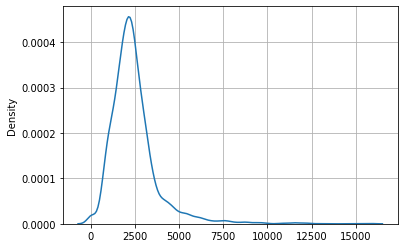

In [ ]:
pxm2 = outliers['price'] / outliers['surface_total']
plt.grid(True)
sns.kdeplot(data=(outliers.loc[pxm2 < 20000, 'price'] / outliers.loc[pxm2 < 20000, 'surface_total']))

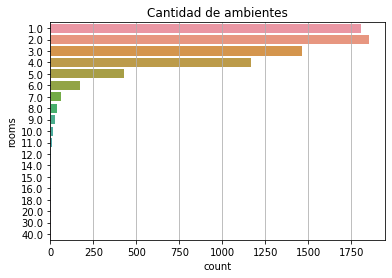

In [ ]:
plt.grid(True)
sns.countplot(data=outliers, y='rooms', orient="h")
plt.title("Cantidad de ambientes")
plt.show()

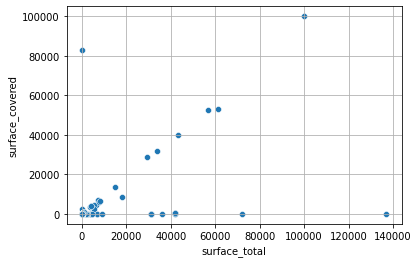

In [ ]:
plt.grid(True)
sns.scatterplot(data=outliers, x='surface_total', y='surface_covered')

In [ ]:
pxm2_filter = pxm2 > 4000
rooms_filter = outliers['rooms'] > 4
surface_filter = outliers['surface_total'] > 15000
outliers[pxm2_filter | rooms_filter | surface_filter].shape[0]

1276

In [ ]:
index = outliers.index[pxm2_filter | rooms_filter | surface_filter]
properati_train.drop(index=index, inplace=True)
properati_train.shape[0]

69939

#### **General**

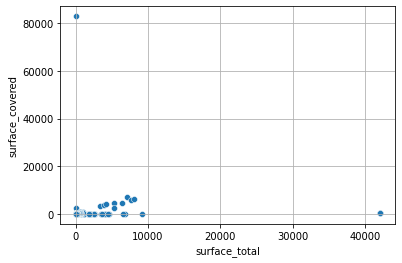

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train, x='surface_total', y='surface_covered')

In [ ]:
surface_outliers = properati_train.loc[(properati_train['surface_covered'] > 80000) | (properati_train['surface_total'] > 40000), :]
surface_outliers.head()

,start_date,end_date,created_on,latitud,longitud,district,subdistrict,property_type,rooms,bedrooms,surface_total,surface_covered,price
41142,2021-07-25,9999-12-31,2021-07-25,-34.604362,-58.392366,Barrio Norte,NaN,Departamento,4.0,NaN,83.0,83000.0,155000.0
75058,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,2890500.0
75057,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,2890500.0
75056,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,3044250.0


In [ ]:
properati_train.loc[41142, 'surface_covered'] = 83
surface_outliers = properati_train.loc[(properati_train['surface_covered'] > 80000) | (properati_train['surface_total'] > 40000), :]
surface_outliers.head()

,start_date,end_date,created_on,latitud,longitud,district,subdistrict,property_type,rooms,bedrooms,surface_total,surface_covered,price
75058,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,2890500.0
75057,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,2890500.0
75056,2021-04-24,2021-06-05,2021-04-24,-34.571747,-58.422612,Palermo,NaN,Departamento,5.0,4.0,42110.0,307.0,3044250.0


In [ ]:
properati_train.drop(index=surface_outliers.index, inplace=True)

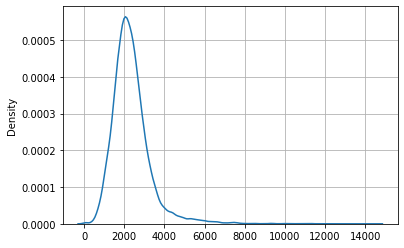

In [ ]:
plt.grid(True)
sns.kdeplot(data=(properati_train['price'] / properati_train['surface_total']))

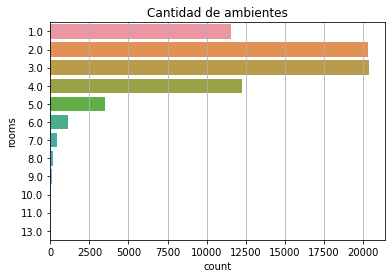

In [ ]:
plt.grid(True)
sns.countplot(data=properati_train, y='rooms', orient="h")
plt.title("Cantidad de ambientes")
plt.show()

### **d) Reducción de la dimensionalidad**

*   Fechas: Eliminamos las columnas por una muy baja correlacion con el precio.
*   Latitud y Longitud: Nos la quedamos por el grafico deducimos que es util.
*   Distric: Nos la quedamos hay una evidente diferencia de precio por distrito.
*   Subdistric: Los pocos datos los pasamos a distric el resto los eliminamos.
*   Tipo de propiedad: Lo mismo que con distrct, nos lo quedamos.
*   Rooms: Hay una clara correlacion con el precio nos la quedamos.
*   Bedrooms: La eliminamos, consideramos que no agrega mucha mas info que Rooms
*   Superficie Total: Tiene alta correlacion con el precio nos lo quedamos.
*   Superficie Cubierta: Tiene alta correlacion con el precio nos lo quedamos.

In [ ]:
def drop_irrelevant_variables(df):
  drop_columns = ['start_date', 'end_date', 'created_on', 'subdistrict', 'bedrooms']
  df.drop(columns=drop_columns, inplace=True)

In [ ]:
def drop_outliers_mahalanobis(df):
  for property_type in ['Casa', 'PH', 'Departamento']:
    drop_outliers_by_property_type(df, property_type)

In [ ]:
drop_irrelevant_variables(properati_train)
properati_train.reset_index(drop=True, inplace=True)
properati_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69936 entries, 0 to 69935
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitud          69936 non-null  float64
 1   longitud         69936 non-null  float64
 2   district         69936 non-null  object 
 3   property_type    69936 non-null  object 
 4   rooms            69936 non-null  float64
 5   surface_total    69936 non-null  float64
 6   surface_covered  69936 non-null  float64
 7   price            69936 non-null  float64
dtypes: float64(6), object(2)
memory usage: 4.3+ MB


In [ ]:
def apply_all_transformations(df):
  merge_distric_with_subdistric(df)
  apply_missing_district_transformation(df)
  apply_missing_rooms_transformation(df)
  apply_coords_transformation(df)
  apply_missing_surface_transformation(df)
  drop_irrelevant_variables(df)
  drop_outliers_mahalanobis(df)
  df.reset_index(drop=True, inplace=True)

In [ ]:
apply_all_transformations(properati_test)
properati_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17148 entries, 0 to 17147
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitud          17148 non-null  float64
 1   longitud         17148 non-null  float64
 2   district         17148 non-null  object 
 3   property_type    17148 non-null  object 
 4   rooms            17148 non-null  float64
 5   surface_total    17148 non-null  float64
 6   surface_covered  17148 non-null  float64
 7   price            17148 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.0+ MB


## **2. Agrupamiento**

Empezemos por analizar la tendencia al clustering usando la estadistica de Hopkins

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
!pip install pyclustertend
from pyclustertend import hopkins

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
numeric_values = properati_train.loc[:, ['latitud', 'longitud', 'rooms', 'surface_total', 'surface_covered', 'price']]

cluster_tendency = hopkins(numeric_values,numeric_values.shape[0])
print("Estadistica de Hopkins: ", cluster_tendency)

Estadistica de Hopkins:  0.0005318325131293268


La tendencia al clustering es muy baja. Esto significa que las propiedades tienden a estar distribuidas de forma uniforme respecto a sus variables.

Voy a usar la regla del codo para ver como perfoman los clusters segun la cantidad.

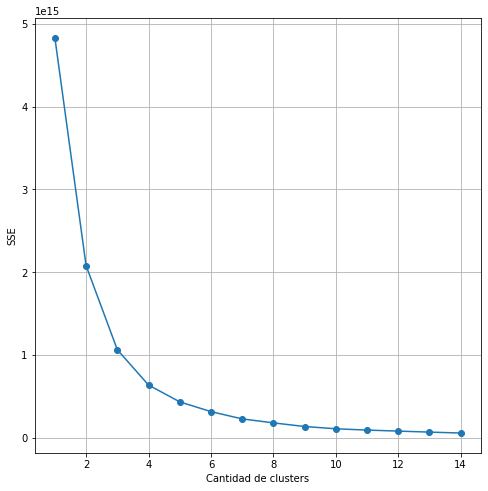

In [ ]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=2)
    km.fit(numeric_values)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

Es una curva muy suave asi que es dificil decir cual es la cantidad optima de clusters mediante la regla del codo. Voy a usar el silhouette score.

In [ ]:
# Esta celda tarda un tiempito en correr
list_k = list(range(4, 11))

for n_clusters in list_k:
  clusterer = KMeans(n_clusters=n_clusters, random_state=2)
  preds = clusterer.fit_predict(numeric_values)

  score = silhouette_score (numeric_values, preds)
  print ("For " + str(n_clusters) + " clusters, silhouette score is " + str(score))

For 4 clusters, silhouette score is 0.6919293138130284
For 5 clusters, silhouette score is 0.6458574636497558
For 6 clusters, silhouette score is 0.6339156559491642
For 7 clusters, silhouette score is 0.592298881794331
For 8 clusters, silhouette score is 0.5732954587545436
For 9 clusters, silhouette score is 0.5661446946479387
For 10 clusters, silhouette score is 0.5578499640570699


Hay una caida del silhoutte score mas pronunciada entre 4 y 5 clusters. Parece que la cantidad optima es de 4 clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=2)
clusters = kmeans.fit_predict(numeric_values)

In [ ]:
pd.Series(clusters).value_counts()

0    56621
2    11251
1     1732
3      332
dtype: int64

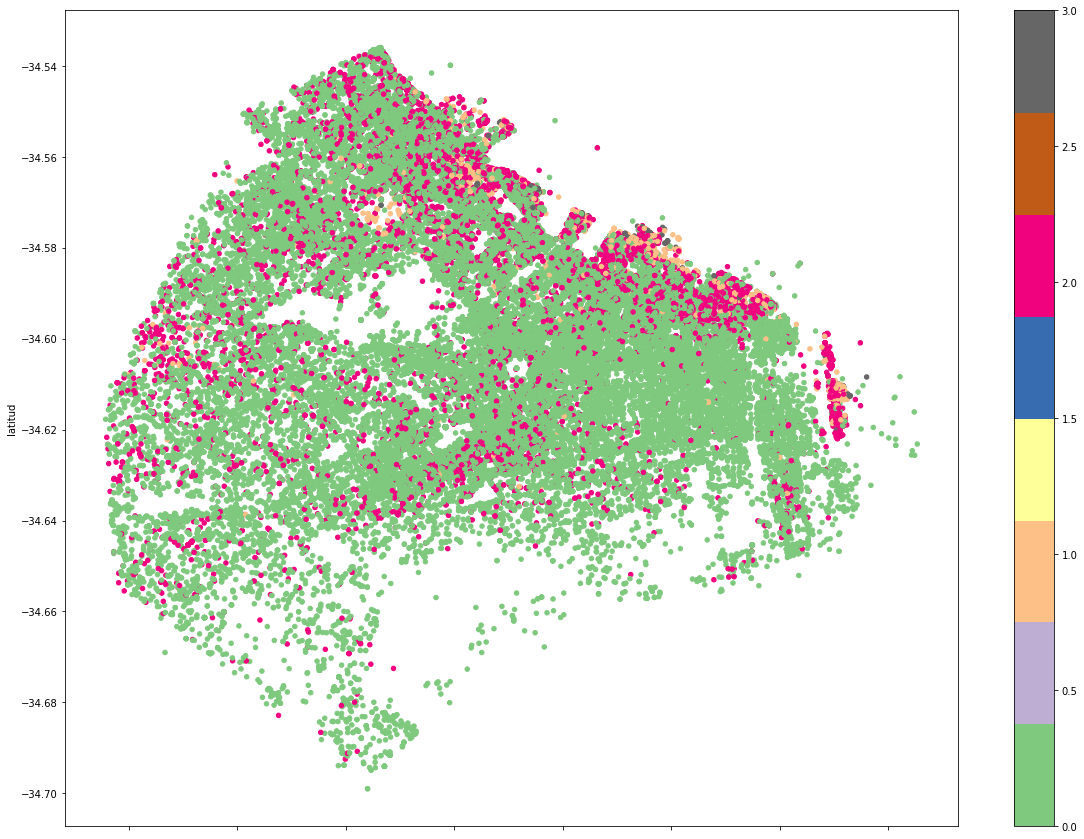

In [ ]:
properati_train.plot(kind="scatter", x="longitud", y="latitud", c=clusters, figsize=(20,15),cmap=plt.get_cmap("Accent"), colorbar=True)
plt.show()

Viendo el grafico se pueden intuir algunas cosas: 


*   El cluster 0 es el mas predominante. Abarca toda la capital. Intuyo que se trata de departamentos chicos y baratos.
*   Le sigue el cluster 2. Tambien esta distribuido casi por toda la capital pero con zonas menos densas en zona sur y el centro. Seguro se trate de casas y departamentos grandes.
*   Los clusters 1 y 3 predominan en zona norte siguiendo la costanera. Tambien hay algunas masas en Belgrano R y Villa Devoto. Seguro se trate de casas y departamentos de mayor poder adquisitivo.

Voy a analizar cada cluster.



#### **Grupo 0**

In [ ]:
group = properati_train.loc[clusters == 0, :]
print("Propiedades en el grupo 0: ", group.shape[0])

Propiedades en el grupo 0:  56621


In [ ]:
mean_price = group['price'].mean()
mean_covered = group['surface_covered'].mean()
mean_total = group['surface_total'].mean()
mean_rooms = group['rooms'].mean()

print("Informacion sobre las propiedades en el grupo 0")
print(f"Precio promedio: ${mean_price:,.0f}")
print(f"Superficie cubierta promedio: {mean_covered:,.2f} m2")
print(f"Superficie total promedio: {mean_total:,.2f} m2")
print(f"Ambientes promedio: {mean_rooms:,.0f} ambientes")

Informacion sobre las propiedades en el grupo 0
Precio promedio: $130,622
Superficie cubierta promedio: 56.66 m2
Superficie total promedio: 68.26 m2
Ambientes promedio: 2 ambientes


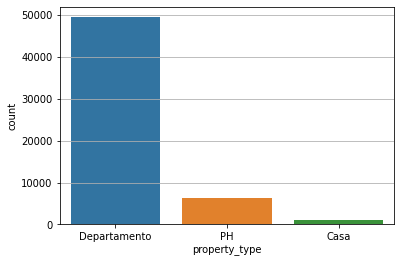

In [ ]:
plt.grid(True)
sns.countplot(x='property_type', data=group)
plt.show()

#### **Grupo 2**

In [ ]:
group = properati_train.loc[clusters == 2, :]
print("Propiedades en el grupo 2: ", group.shape[0])

Propiedades en el grupo 2:  11251


In [ ]:
mean_price = group['price'].mean()
mean_covered = group['surface_covered'].mean()
mean_total = group['surface_total'].mean()
mean_rooms = group['rooms'].mean()

print("Informacion sobre las propiedades en el grupo 2")
print(f"Precio promedio: ${mean_price:,.0f}")
print(f"Superficie cubierta promedio: {mean_covered:,.2f} m2")
print(f"Superficie total promedio: {mean_total:,.2f} m2")
print(f"Ambientes promedio: {mean_rooms:,.0f} ambientes")

Informacion sobre las propiedades en el grupo 2
Precio promedio: $395,390
Superficie cubierta promedio: 130.66 m2
Superficie total promedio: 155.85 m2
Ambientes promedio: 4 ambientes


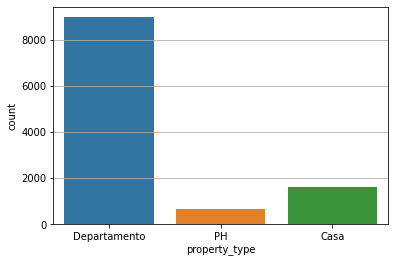

In [ ]:
plt.grid(True)
sns.countplot(x='property_type', data=group)
plt.show()

#### **Grupo 1**

In [ ]:
group = properati_train.loc[clusters == 1, :]
print("Propiedades en el grupo 2: ", group.shape[0])

Propiedades en el grupo 2:  1732


In [ ]:
mean_price = group['price'].mean()
mean_covered = group['surface_covered'].mean()
mean_total = group['surface_total'].mean()
mean_rooms = group['rooms'].mean()

print("Informacion sobre las propiedades en el grupo 1")
print(f"Precio promedio: ${mean_price:,.0f}")
print(f"Superficie cubierta promedio: {mean_covered:,.2f} m2")
print(f"Superficie total promedio: {mean_total:,.2f} m2")
print(f"Ambientes promedio: {mean_rooms:,.0f} ambientes")

Informacion sobre las propiedades en el grupo 1
Precio promedio: $1,066,961
Superficie cubierta promedio: 240.09 m2
Superficie total promedio: 268.30 m2
Ambientes promedio: 5 ambientes


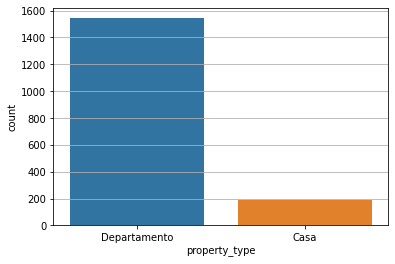

In [ ]:
plt.grid(True)
sns.countplot(x='property_type', data=group)
plt.show()

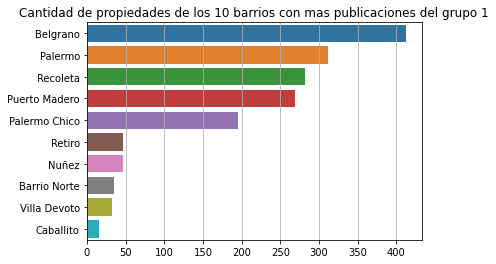

In [ ]:
districts = group['district'].value_counts()
plt.grid(True)
sns.barplot(x=districts.array[0:10], y=districts.index[0:10], orient="h")
plt.title("Cantidad de propiedades de los 10 barrios con mas publicaciones del grupo 1")
plt.show()

#### **Grupo 3**

In [ ]:
group = properati_train.loc[clusters == 3, :]
print("Propiedades en el grupo 2: ", group.shape[0])

Propiedades en el grupo 2:  332


In [ ]:
mean_price = group['price'].mean()
mean_covered = group['surface_covered'].mean()
mean_total = group['surface_total'].mean()
mean_rooms = group['rooms'].mean()

print("Informacion sobre las propiedades en el grupo 3")
print(f"Precio promedio: ${mean_price:,.0f}")
print(f"Superficie cubierta promedio: {mean_covered:,.2f} m2")
print(f"Superficie total promedio: {mean_total:,.2f} m2")
print(f"Ambientes promedio: {mean_rooms:,.0f} ambientes")

Informacion sobre las propiedades en el grupo 3
Precio promedio: $2,770,666
Superficie cubierta promedio: 366.49 m2
Superficie total promedio: 407.12 m2
Ambientes promedio: 6 ambientes


In [ ]:
group['property_type'].value_counts()

Departamento    332
Name: property_type, dtype: int64

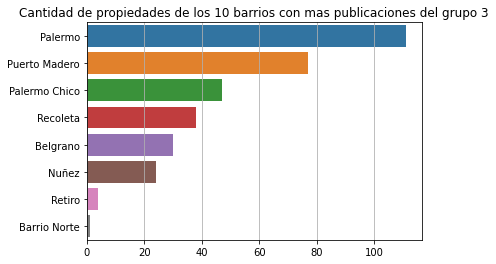

In [ ]:
districts = group['district'].value_counts()
plt.grid(True)
sns.barplot(x=districts.array[0:10], y=districts.index[0:10], orient="h")
plt.title("Cantidad de propiedades de los 10 barrios con mas publicaciones del grupo 3")
plt.show()

## **3. Clasificacion**


a) Construccion del Target

In [ ]:
properati_train.shape[0]

71915

In [ ]:
#df = backup_train.copy()
#apply_all_transformations(df)
df = filtro_precio_m2(properati_train).copy()
df.shape[0]

70799

Creo la variable Precio por metro cuadrado. 

In [ ]:
pxm2 = df['price'] / df["surface_total"]

1. Divido precio por m2 en tres intervalos iguales.

In [ ]:
df["pmx2_a"] = pd.qcut(pxm2, 3, labels=["bajo", "medio", "alto"])

2. Divido precio por m2 en tres categorias la primera va de 0 a q1, la segunda selecciona aquellos valores dentro del rango inter cuartilico y la tercera va de q3 hacia arriba.

In [ ]:
df["pmx2_b"]  = pd.qcut(pxm2, q= [0, .25, .75, 1.], labels=["bajo", "medio", "alto"])

3. Divido precio por m2 primero seleccionando tipo de propiedad y despues aplicando la divicion del punto dos al tipo de propiedad en cuestion.

In [ ]:
df['pxm2'] = pxm2


In [ ]:
df_by_property_type = []

for property_type in ['Departamento', 'PH', 'Casa']:
  filtered_by_property_type = df[df.property_type == property_type].copy()
  filtered_by_property_type["pmx2_c"] = pd.qcut(filtered_by_property_type['pxm2'], q= [0, .25, .75, 1.], labels=["bajo", "medio", "alto"])
  df_by_property_type.append(filtered_by_property_type.copy())

df = pd.concat(df_by_property_type)

In [ ]:
df_by_property_type = []

for property_type in ['Departamento', 'PH', 'Casa']:
  filtered_by_property_type = df[df.property_type == property_type].copy()
  filtered_by_property_type["pmx2_c"] = pd.qcut(filtered_by_property_type['pxm2'], q= [0, .25, .75, 1.], labels=[1, 2, 3])
  df_by_property_type.append(filtered_by_property_type.copy())

df = pd.concat(df_by_property_type)

In [ ]:
pmx2_c = df["pmx2_c"]

Distribucion de precio por metro cuadrado

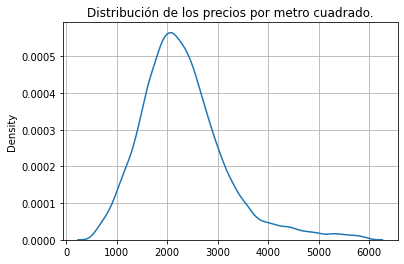

In [ ]:
plt.grid(True)
sns.kdeplot(data=pxm2)
plt.title("Distribución de los precios por metro cuadrado.")
plt.show()

Distribucion de precio por metro cuadrado por tipo de propiedad.

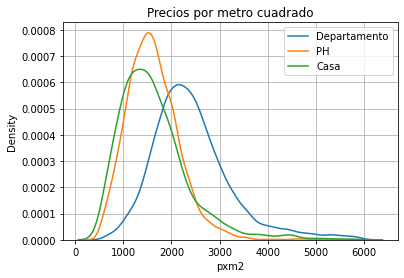

In [ ]:
plt.grid(True)
for property_type in ['Departamento', 'PH', 'Casa']:
  filtered_by_property_type = df[df.property_type == property_type]
  sns.kdeplot(data=filtered_by_property_type.pxm2, label=property_type)
  plt.title("Precios por metro cuadrado")   
plt.legend()
plt.show()

Grafico cada una de las variables categoricas.

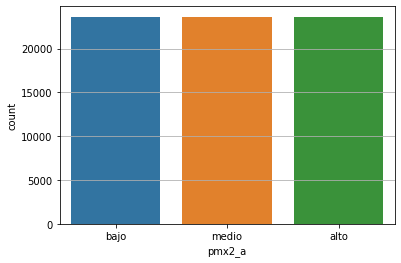

In [ ]:
# Grafico la variable categorica uniforme
plt.grid(True)
sns.countplot(x='pmx2_a', data=df)
plt.show()

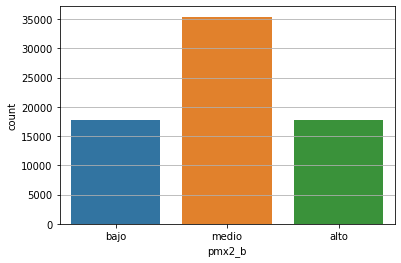

In [ ]:
# Grafico la variable categorica distribuida [0, q1, q3, inf]
plt.grid(True)
sns.countplot(x='pmx2_b', data=df)
plt.show()

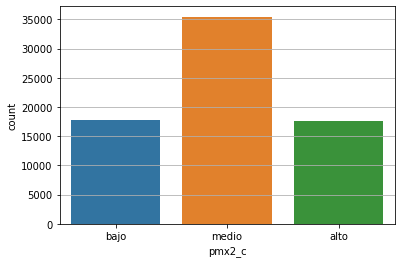

In [ ]:
# Grafico la variable categorica primero discriminando por tipo de propiedad y despues distribuida [0, q1, q3, inf]
plt.grid(True)
sns.countplot(x='pmx2_c', data=df)
plt.show()

Vamos a seleccionar el tercer caso:

1. El primer caso lo descartamos, dado que evidentemente la distribucion tiene mas que ver con una distribucion normal que con una uniforme.

2. Si bien entre el segundo y el tercero no hay mucha diferencia por el grafico de distribucion vemos que hay diferencias eviententes entre cada tipo de propiedad.

Grafico sobre caba con la categoria del precio.

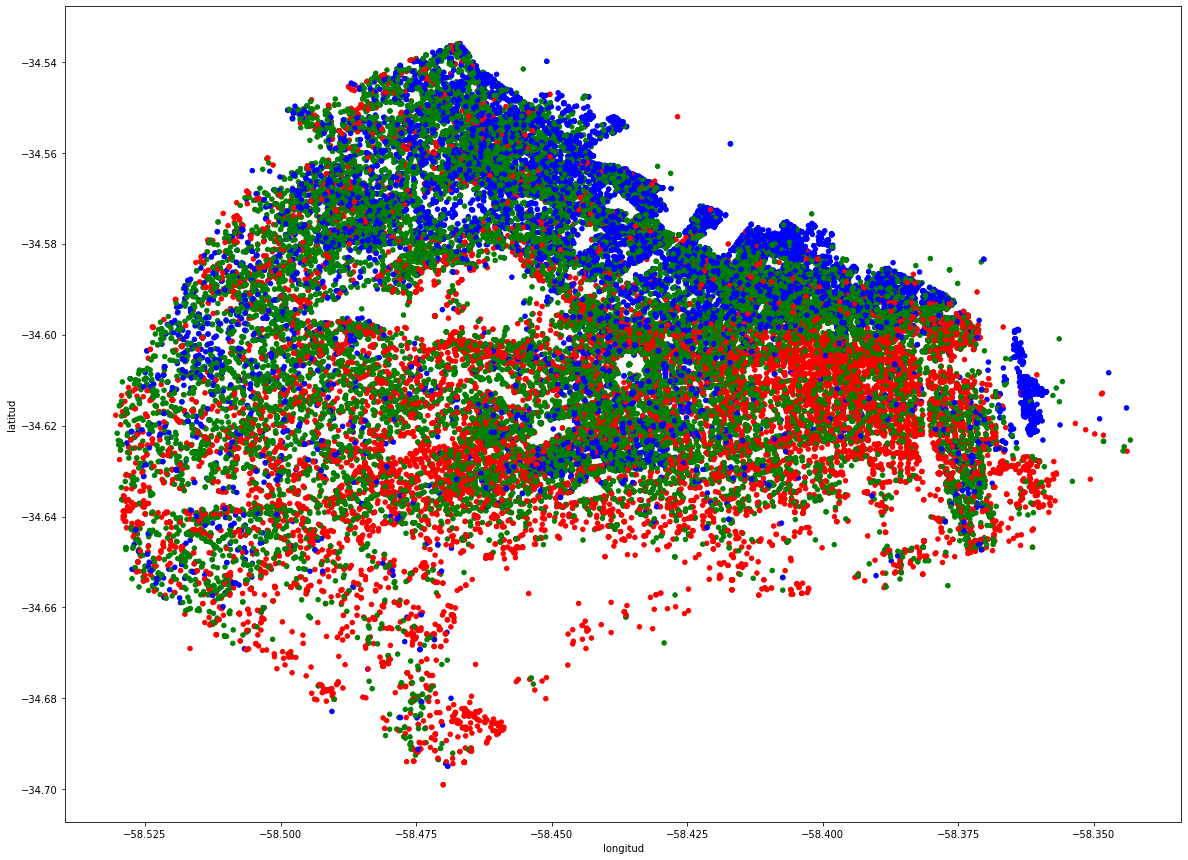

In [ ]:
colors = {'bajo':'red', 'medio':'green', 'alto':'blue'}
df.plot(kind="scatter", x="longitud", y="latitud", c=pmx2_c.map(colors), figsize=(20,15))
plt.show()

b) Entrenamiento y Prediccion

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def split_target(df):
    return df.loc[:, ~df.columns.isin(["price", "pmx2_a", "pmx2_b", "pmx2_c", "pxm2", "month"])], df["pmx2_c"]

def encoding_transformation(df):
  encoder_property_type = OneHotEncoder()
  result = encoder_property_type.fit_transform(df[["property_type"]])
  df = df.join(pd.DataFrame(result.toarray(), columns=encoder_property_type.categories_[0]))
  df.drop(["property_type", "Casa"], axis=1, inplace=True)
  encoder_district = OneHotEncoder()
  result = encoder_district.fit_transform(df[["district"]])
  df = df.join(pd.DataFrame(result.toarray(), columns=encoder_district.categories_[0]))
  df.drop(["district", "Abasto"], axis=1, inplace=True)
  return df


def encode_pandas(df):
  return pd.get_dummies(df, columns=['property_type', "district"])

def scaling_transformation(df):
  scaler = StandardScaler()
  return scaler.fit_transform(df)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
X_train, y_train = split_target(df)
X_train_encoded = encode_pandas(X_train)

tree_clas = DecisionTreeClassifier(max_depth=5)
scores = cross_val_score(tree_clas, X_train_encoded, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [0.66191812 0.65828059 0.66585402 0.66489879 0.65709943 0.66712555
 0.65913828 0.67113615 0.71396482 0.86273644]
Mean: 0.688215218648745
Standard deviation: 0.06025124677462354


## **4. Regresión**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [ ]:
def one_hot_property_type(df):
  df_encoded = pd.get_dummies(df, columns=['property_type'], drop_first=True)
  columns_rename = {"property_type_Departamento":"type_dpto", "property_type_PH":"type_ph"}
  return df_encoded.rename(columns=columns_rename)

In [ ]:
train_set = one_hot_property_type(properati_train)
test_set = one_hot_property_type(properati_test)

features = ['latitud', 'longitud', 'rooms', 'surface_total', 'surface_covered', 'type_dpto', 'type_ph']
target = 'price'
scaler = StandardScaler()

x_train = scaler.fit_transform(train_set.loc[:, features])
x_test = scaler.transform(test_set.loc[:, features])
y_train = train_set.loc[:, target]
y_test = test_set.loc[:, target]

### **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Se va a utilizar un random search de 15 iteraciones con 5 folds para determinar los hiperparametros optimos.

In [ ]:
params_grid={ 'n_neighbors':range(3,30), 
              'weights':['distance','uniform'],
              'leaf_size':range(20,40),
              'metric':['euclidean','manhattan','chebyshev']
             }

estimator = KNeighborsRegressor()

rand_search = RandomizedSearchCV(estimator, params_grid, cv=5, n_iter=15, random_state=2)
rand_search.fit(x_train, y_train)
rand_search.cv_results_['mean_test_score']

array([0.82428839, 0.86409389, 0.88478133, 0.86161197, 0.9046771 ,
       0.84533866, 0.8846877 , 0.89672043, 0.86596058, 0.87374755,
       0.83694523, 0.85813305, 0.84525073, 0.84787553, 0.89631606])

In [ ]:
print(rand_search.best_params_)
print("Best R2 score: ", rand_search.best_score_)

{'weights': 'distance', 'n_neighbors': 18, 'metric': 'manhattan', 'leaf_size': 35}
Best R2 score:  0.9046771042025897


In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=18, weights='distance', leaf_size=35, metric='manhattan')
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_test)
print("R2 score: ", knn_regressor.score(x_test, y_test))

R2 score:  0.8626880563375959


In [ ]:
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error cuadratico medio del test es: {mse:,.2f}")

El error cuadratico medio del test es: 2,366,688,437.00


In [ ]:
mae = metrics.mean_absolute_error(
        y_true  = y_test,
        y_pred  = y_pred,
       )

print(f"El error absoluto medio del test es: ${mae:,.0f}")

El error absoluto medio del test es: $23,950


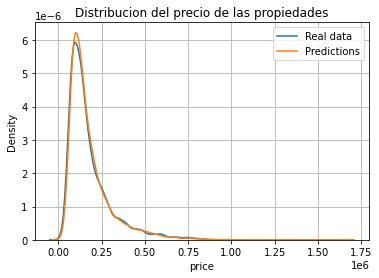

In [ ]:
plt.grid(True)
sns.kdeplot(data=y_test, label='Real data')
sns.kdeplot(data=y_pred, label='Predictions')
plt.title("Distribucion del precio de las propiedades")
plt.legend()
plt.show()

### **XGBoost**

[Material de referencia para optimizar hiperparametros](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/)

In [ ]:
import xgboost as xgb

In [ ]:
params_grid={ 'learning_rate':np.arange(0.01, 0.5, step=0.01),
              'n_estimators':range(90, 200, 10),
              'max_depth':range(2, 8),
              'min_child_weight':range(1, 7, 2),
              'subsample':np.arange(0.1, 1, step=0.1),
              'gamma':np.arange(0.05, 1, step=0.05),
              'lambda':np.arange(0.01, 0.1, step=0.01),
              'alpha':np.arange(0, 0.5, step=0.1),
              'objective':['reg:squarederror']
             }

estimator = xgb.XGBRegressor()
rand_search = RandomizedSearchCV(estimator, params_grid, cv=5, n_iter=20, random_state=2)
rand_search.fit(x_train, y_train)
rand_search.cv_results_['mean_test_score']

array([0.90543376, 0.83935595, 0.8975846 , 0.8949394 , 0.90608104,
       0.88016881, 0.90179565, 0.83426324, 0.89885703, 0.88373549,
       0.89735399, 0.87539263, 0.88607962, 0.84197049, 0.61234103,
       0.90658454, 0.8566006 , 0.86062048, 0.8771578 , 0.90733919])

In [ ]:
print(rand_search.best_params_)
print("Best R2 score: ", rand_search.best_score_)

{'subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 160, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.17, 'lambda': 0.06999999999999999, 'gamma': 0.9000000000000001, 'alpha': 0.4}
Best R2 score:  0.907339193412852


In [ ]:
xgb_regressor = xgb.XGBRegressor(learning_rate=0.17, n_estimators=160, max_depth=7, min_child_weight=3, subsample=0.5, gamma=0.9000000000000001, reg_lambda=0.06999999999999999, alpha=0.4, objective='reg:squarederror')
xgb_regressor.fit(x_train, y_train)
y_pred = xgb_regressor.predict(x_test)
print("R2 score: ", xgb_regressor.score(x_test, y_test))

R2 score:  0.8271138733295825


In [ ]:
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error cuadratico medio del test es: {mse:,.2f}")

El error cuadratico medio del test es: 2,979,839,815.79


In [ ]:
mae = metrics.mean_absolute_error(
        y_true  = y_test,
        y_pred  = y_pred,
       )

print(f"El error absoluto medio del test es: ${mae:,.0f}")

El error absoluto medio del test es: $33,276


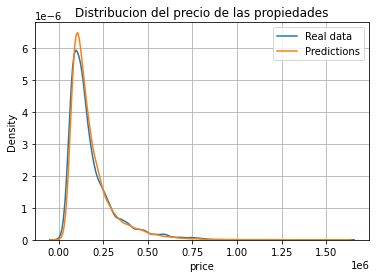

In [ ]:
plt.grid(True)
sns.kdeplot(data=y_test, label='Real data')
sns.kdeplot(data=y_pred, label='Predictions')
plt.title("Distribucion del precio de las propiedades")
plt.legend()
plt.show()

### **Regresión Lineal**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)
y_pred = linear_regressor.predict(x_test)
print("R2 score: ", linear_regressor.score(x_test, y_test))

R2 score:  0.4802962608733715


In [ ]:
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error cuadratico medio del test es: {mse:,.2f}")

El error cuadratico medio del test es: 8,957,537,103.13


In [ ]:
mae = metrics.mean_absolute_error(
        y_true  = y_test,
        y_pred  = y_pred,
       )

print(f"El error absoluto medio del test es: ${mae:,.0f}")

El error absoluto medio del test es: $70,890


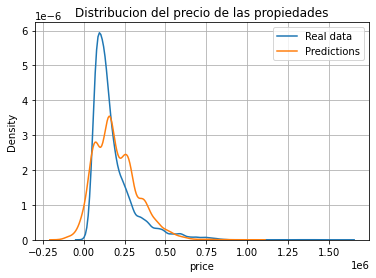

In [ ]:
plt.grid(True)
sns.kdeplot(data=y_test, label='Real data')
sns.kdeplot(data=y_pred, label='Predictions')
plt.title("Distribucion del precio de las propiedades")
plt.legend()
plt.show()

# **Borrador**

#### **Superficie**

In [ ]:
print(f"Superficie total maxima: {properati_train['surface_total'].max():,.0f} m2")
print(f"Superficie total minima: {properati_train['surface_total'].min():,.0f} m2")

#### **Ambientes**




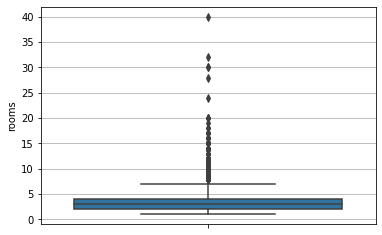

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train['rooms'])
plt.show()

Aplicamos el metodo de filtrado de outliers, estableciendo un limite superior como el tercer cuartil sumado 1.5 veces el indice inter cuartilico (iqr)



In [ ]:
q1 = np.nanpercentile(properati_train['rooms'], 25)
q3 = np.nanpercentile(properati_train['rooms'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print(upper_bound)

7.0


In [ ]:
print(properati_train['rooms'].max())
print(properati_train['rooms'].min())

40.0
1.0


In [ ]:
room_outliers = properati_train.loc[properati_train['rooms'] > upper_bound, :]
room_outliers.shape[0]

585

Mas que nada quiero ver que las otras variables se correspondan con la cantidad de ambientes.

In [ ]:
q1 = properati_train.groupby('property_type')["rooms"].quantile(.25)
q3 = properati_train.groupby('property_type')["rooms"].quantile(.75)
iqr = q3 - q1
upper_bound = round(q3 + 1.5 * iqr)
print(upper_bound)
properati_train.rooms <= upper_bound['Casa']

property_type
Casa            9.0
Departamento    4.0
PH              6.0
Name: rooms, dtype: float64


52019    True
5554     True
46754    True
73268    True
31859    True
         ... 
84434    True
31019    True
44566    True
72173    True
89256    True
Name: rooms, Length: 71915, dtype: bool

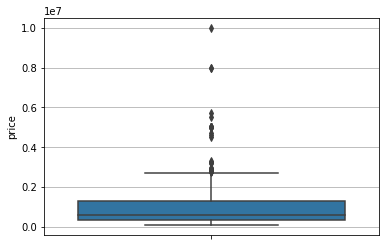

In [ ]:
plt.grid(True)
sns.boxplot(y=room_outliers['price'])

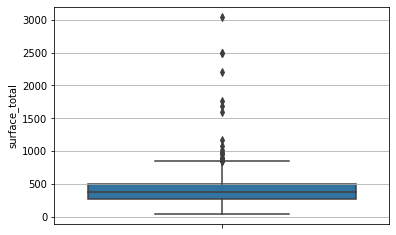

In [ ]:
plt.grid(True)
sns.boxplot(y=room_outliers['surface_total'])

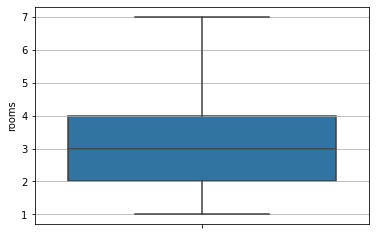

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train[properati_train.rooms <= upper_bound]["rooms"])
plt.show()

Sabemos que hay casas con mas habitaciones que 7, por lo que vamos a aplicar el mismo metodo pero diferenciando por tipo de propiedad.

In [ ]:
dataframe  = properati_train.copy()

In [ ]:
q1 = properati_train.groupby('property_type')["rooms"].quantile(.25)
q3 = properati_train.groupby('property_type')["rooms"].quantile(.75)
upper_bound = q3 + 1.5 * iqr

def filter_by_property_bound(df, property_type, bound):
  return (df.rooms <= bound[property_type]) & (df.property_type == property_type)
             
properati_train = properati_train[filter_by_property_bound(properati_train, "Casa", upper_bound) | filter_by_property_bound(properati_train, "Departamento", upper_bound) | filter_by_property_bound(properati_train, "PH", upper_bound) ]

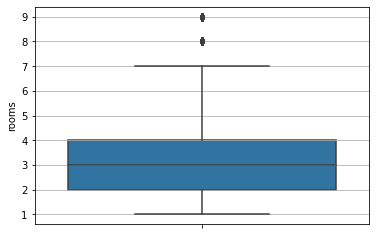

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["rooms"])
plt.show()

In [ ]:
def filter_outliers_by_bound(df, property_type, bound, column):
  return (df[column] <= bound[property_type]) & (df.property_type == property_type)

def filter_outliers_by_property(dataframe, column):
  q1 = dataframe.groupby('property_type')[column].quantile(.25)
  q3 = dataframe.groupby('property_type')[column].quantile(.75)
  upper_bound = q3 + 1.5 * iqr
  return dataframe[filter_outliers_by_bound(dataframe, "Casa", upper_bound, column) | filter_outliers_by_bound(dataframe, "Departamento", upper_bound, column) | filter_outliers_by_bound(dataframe, "PH", upper_bound, column)]

Vamos a quedarnos con este metodo para filtrar outliers, tambien lo aplicaremos para el caso de superficies.



3. Superficies


In [ ]:
properati_train.head()

,latitud,longitud,district,property_type,rooms,surface_total,surface_covered,price
52019,-34.566536,-58.479638,Coghlan,Departamento,2.0,65.00,53.0,198000.0
5554,-34.645625,-58.459408,Flores,Departamento,1.0,29.00,29.0,63000.0
46754,-34.577033,-58.423367,Palermo,Departamento,1.0,49.00,44.0,160000.0
73268,-34.580210,-58.412815,Palermo,Departamento,1.0,103.59,78.0,290000.0
31859,-34.582107,-58.448826,Palermo,Departamento,1.0,36.00,31.0,83789.0


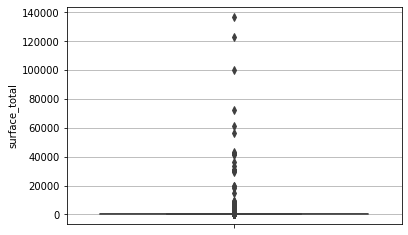

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["surface_total"])
plt.show()

In [ ]:
properati_train = filter_outliers_by_property(properati_train, "surface_total")

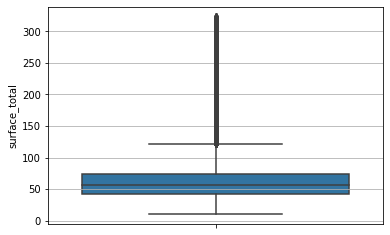

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["surface_total"])
plt.show()

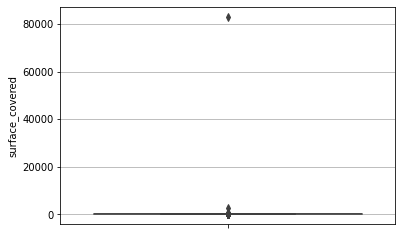

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["surface_covered"])
plt.show()

Utilizo el limite establecido por el de la superficie total aprox 400 para capear el de superficie cubierta.

In [ ]:
properati_train = properati_train[properati_train.surface_covered < 400]

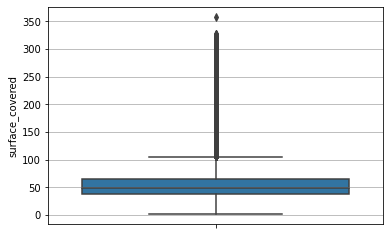

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["surface_covered"])
plt.show()

4) Precio

Vamos a analizar outliers de precios.

Vemos que hay outliers tanto por debajo como por arriba.

In [ ]:
dataframe = properati_train.copy()

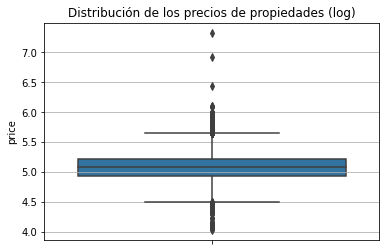

In [ ]:
plt.grid(True)
price_log = np.log10(properati_train['price'])
sns.boxplot(y=price_log)
plt.title("Distribución de los precios de propiedades (log)")
plt.show()

Vamos a crear una variable que sea precio por metro cuadrado

In [ ]:
precio_metro_cuadrado = properati_train['price'] / properati_train['surface_total'] 

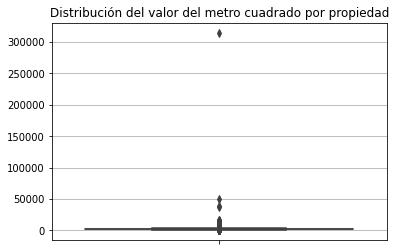

In [ ]:
plt.grid(True)
sns.boxplot(y=precio_metro_cuadrado)
plt.title("Distribución del valor del metro cuadrado por propiedad")
plt.show()

Vamos a utlizar el valor por m2 para filtrar por abajo y por arriba a los outliers, utilizando al limite inferior al q1 - 1.5 * iqr y el superior 
q3 + 1.5 * iqr

In [ ]:
q1 = np.nanpercentile(precio_metro_cuadrado, 25)
q3 = np.nanpercentile(precio_metro_cuadrado, 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr
filtred = precio_metro_cuadrado[(precio_metro_cuadrado > lower_bound) & (precio_metro_cuadrado < upper_bound)]

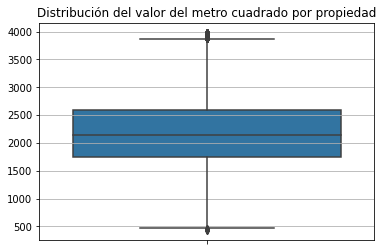

In [ ]:
plt.grid(True)
sns.boxplot(y=filtred)
plt.title("Distribución del valor del metro cuadrado por propiedad")
plt.show()

In [ ]:
properati_train["precio_metro_cuadrado"] =  properati_train['price'] / properati_train['surface_total'] 
properati_train = properati_train[(properati_train["precio_metro_cuadrado"] > lower_bound) & (properati_train["precio_metro_cuadrado"] < upper_bound)] 

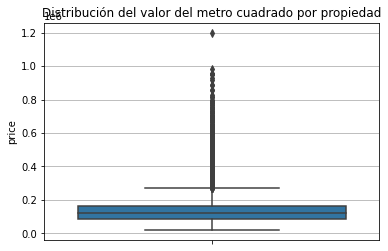

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train["price"])
plt.title("Distribución del valor del metro cuadrado por propiedad")
plt.show()


### Preprocesamiento

In [ ]:
def preprocess_test_transformation(X_test):
  missing_district_transformation(X_test)
  missing_rooms_transformation(X_test)
  missing_surface_transformation(X_test)
  X_test = merge_distric_with_subdistric(X_test)
  X_test = final_variables(X_test)
  X_test = coords_transformation(X_test)
  X_test = filter_outliers_by_property(X_test, "rooms")
  X_test = filter_outliers_by_property(X_test, "surface_total")
  X_test = X_test[X_test.surface_covered < 400]
  return X_test.drop(["price"], axis=1), X_test["price"].copy()

In [ ]:
X_test, y_test = preprocess_test_transformation(properati_test)

In [ ]:
def price_transformation(X_train):
  q1 = np.nanpercentile(precio_metro_cuadrado, 25)
  q3 = np.nanpercentile(precio_metro_cuadrado, 75)
  iqr = q3 - q1
  upper_bound = q3 + 1.5 * iqr
  lower_bound = q1 - 1.5 * iqr
  X_train["precio_metro_cuadrado"] =  X_train['price'] / X_train['surface_total'] 
  X_train = X_train[(X_train["precio_metro_cuadrado"] > lower_bound) & (X_train["precio_metro_cuadrado"] < upper_bound)] 
  return X_train

def preprocess_train_transformation(X_train):
  missing_district_transformation(X_train)
  missing_rooms_transformation(X_train)
  missing_surface_transformation(X_train)
  X_train = merge_distric_with_subdistric(X_train)
  X_train = final_variables(X_train)
  X_train = coords_transformation(X_train)
  X_train = filter_outliers_by_property(X_train, "rooms")
  X_train = filter_outliers_by_property(X_train, "surface_total")
  X_train = X_train[X_train.surface_covered < 400]
  X_train = price_transformation(X_train)
  return X_train.drop(["price", "precio_metro_cuadrado"], axis=1), X_train["price"].copy()

In [ ]:
X_train, y_train = preprocess_train_transformation(backup_train)


### Transformaciones Finales 



Transformacion de Variables Categoricas en Numericas

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = properati_train.drop(["price", "precio_metro_cuadrado"], axis=1)

In [ ]:
encoder_property_type = OneHotEncoder()
result = encoder_property_type.fit_transform(df[["property_type"]])
X_train_encoded = X_train.join(pd.DataFrame(result.toarray(), columns=encoder_property_type.categories_[0]))
X_train_encoded.head()

,latitud,longitud,district,property_type,rooms,surface_total,surface_covered,Casa,Departamento,PH
52019,-34.566536,-58.479638,Coghlan,Departamento,2.0,65.0,53.0,0.0,1.0,0.0
5554,-34.645625,-58.459408,Flores,Departamento,1.0,29.0,29.0,0.0,1.0,0.0
46754,-34.577033,-58.423367,Palermo,Departamento,1.0,49.0,44.0,0.0,1.0,0.0
31859,-34.582107,-58.448826,Palermo,Departamento,1.0,36.0,31.0,0.0,1.0,0.0
43512,-34.604367,-58.404872,Once,Departamento,3.0,60.0,50.0,0.0,1.0,0.0


Podemos eliminar uno de los tipos por que no agrega informacion dado que la negacion de los otros dos implica tacitamente que el otro que eliminamos es positivo.

In [ ]:
X_train_encoded.drop(["property_type", "Casa"], axis=1, inplace=True)
X_train_encoded.head()

,latitud,longitud,district,rooms,surface_total,surface_covered,Departamento,PH
52019,-34.566536,-58.479638,Coghlan,2.0,65.0,53.0,1.0,0.0
5554,-34.645625,-58.459408,Flores,1.0,29.0,29.0,1.0,0.0
46754,-34.577033,-58.423367,Palermo,1.0,49.0,44.0,1.0,0.0
31859,-34.582107,-58.448826,Palermo,1.0,36.0,31.0,1.0,0.0
43512,-34.604367,-58.404872,Once,3.0,60.0,50.0,1.0,0.0


In [ ]:
encoder_district = OneHotEncoder()
result = encoder_district.fit_transform(X_train_encoded[["district"]])
X_train_encoded = X_train_encoded.join(pd.DataFrame(result.toarray(), columns=encoder_district.categories_[0]))

In [ ]:
X_train_encoded.drop(["district", "Abasto"], axis=1, inplace=True)
X_train_encoded.head()

,latitud,longitud,rooms,surface_total,surface_covered,Departamento,PH,Agronomía,Almagro,Balvanera,...,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
52019,-34.566536,-58.479638,2.0,65.0,53.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5554,-34.645625,-58.459408,1.0,29.0,29.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46754,-34.577033,-58.423367,1.0,49.0,44.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31859,-34.582107,-58.448826,1.0,36.0,31.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43512,-34.604367,-58.404872,3.0,60.0,50.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nuevamente eliminamos la variable categorica y una de las variables numericas generadas en este caso Abasto.



In [ ]:
def encoding_transformation(X_df):
  encoder_property_type = OneHotEncoder()
  result = encoder_property_type.fit_transform(X_df[["property_type"]])
  X_df = X_df.join(pd.DataFrame(result.toarray(), columns=encoder_property_type.categories_[0]))
  X_df.drop(["property_type", "Casa"], axis=1, inplace=True)
  encoder_district = OneHotEncoder()
  result = encoder_district.fit_transform(X_test[["district"]])
  X_df = X_df.join(pd.DataFrame(result.toarray(), columns=encoder_district.categories_[0]))
  X_df.drop(["district", "Abasto"], axis=1, inplace=True)
  return X_df

Encapsulamos la transformacion para poder aplicarsela al set de test eventualmente.

In [ ]:
cheap_ones = properati_train[properati_train['price'] < q1]
cheap_ones.shape[0]

In [ ]:
plt.grid(True)
sns.kdeplot(data=cheap_ones['price'])

Viendo el grafico pareciera que hay un punto de inflexion  a partir de los $30,000

Voy a tomar ese valor como lower bound

In [ ]:
lower_bound = 30000
cheap_ones = cheap_ones[cheap_ones['price'] < lower_bound]
cheap_ones.shape[0]

In [ ]:
cheap_ones.shape[0] / properati_train.shape[0] * 100

Vemos que la cantidad de propiedades que están por debajo del lower bound corresponden al 0,117% de los datos.

Una propiedad en venta por menos de $30,000 es algo bastante raro. Voy a eliminar estos outliers.

Ademas voy a recalcular el upper bound ya que una propiedad en venta por mas de $445,000 no es algo descabellado. Sacando los outliers bajos me deberia quedar un tercer cuartil mas alto.

In [ ]:
properati_train = properati_train[properati_train['price'] > lower_bound]
print("Precio mas bajo: ", properati_train['price'].min())

In [ ]:
q1 = np.nanpercentile(properati_train['price'], 25)
q3 = np.nanpercentile(properati_train['price'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print("Primer cuartil: ", q1)
print("Tercer cuartil: ", q3)
print("Upper bound: ", upper_bound)

El upper bound apenas subio. Voy a tener que analizar los datos por arriba de este para ver si puedo detectar mejor los outliers

In [ ]:
expensive_ones = properati_train[properati_train['price'] > upper_bound]
expensive_ones.shape[0]

In [ ]:
plt.grid(True)
sns.kdeplot(data=expensive_ones['price'])

En el grafico se aprecia que la gran cantidad de propiedades se encuentran por debajo de los $5,000,000

Este numero tiene sentido. Buscando informacion pareceria que las propiedades por arriba de ese precio son edificios o mansiones mas orientadas a organizaciones que a particulares (ejemplo edificios para poner una empresa, un museo, etc).

In [ ]:
upper_bound = 5000000
expensive_ones = expensive_ones[expensive_ones['price'] > upper_bound]
expensive_ones.shape[0]

Solo 15. Es bastante seguro eliminarlas del dataframe.

In [ ]:
properati_train = properati_train[properati_train['price'] < upper_bound]
plt.grid(True)
price_log = np.log10(properati_train['price'])
sns.boxplot(y=price_log)

Pudimos resolver el problema de los outliers por debajo pero todavia quedan muchos outliers por arriba. Voy a tratar de filtrar algunos mas.

In [ ]:
q1 = np.nanpercentile(properati_train['price'], 25)
q3 = np.nanpercentile(properati_train['price'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print("Primer cuartil: ", q1)
print("Tercer cuartil: ", q3)
print("Upper bound: ", upper_bound)

In [ ]:
expensive_ones = properati_train[properati_train['price'] > upper_bound]
expensive_ones.shape[0]

In [ ]:
plt.grid(True)
sns.kdeplot(data=expensive_ones['price'])

La caida de densidad esta entre el millon y los dos millones. Me voy a quedar solo con las propiedades por debajo de los $1,500,000



In [ ]:
upper_bound = 1500000
properati_train = properati_train[properati_train['price'] < upper_bound]
plt.grid(True)
price_log = np.log10(properati_train['price'])
sns.boxplot(y=price_log)

In [ ]:
properati_train.shape[0]

Creo que este rango de precios es bastante representativo de la realidad. Se eliminaron unos 1000 registros

#### **Ambientes**

In [ ]:
na_rooms = properati_train['rooms'].isna().sum()
print("Null room count: ", na_rooms)
print("Percentage: ", na_rooms / properati_train.shape[0] * 100)

In [ ]:
properati_train['rooms'].corr(properati_train['bedrooms'])

Vemos que la correlación entre 'rooms' (ambientes) y 'bedrooms' (dormitorios) es muy grande. Voy a usar 'bedrooms' para llenar los nul de 'rooms'. Esto lo voy a hacer, por ahora, tomando 'rooms' = 'bedrooms' pero se podria hacer con un modelo mas complejo

In [ ]:
filter = properati_train['rooms'].isna() & properati_train['bedrooms'].notna()
pd.set_option('mode.chained_assignment', None)
properati_train.loc[filter, 'rooms'] = properati_train.loc[filter, 'bedrooms']
pd.reset_option("mode.chained_assignment")
print("Remaining null: ", properati_train['rooms'].isna().sum())

Se pudo reducir los registros con ambientes nulos a 276. Estos se van a eliminar ya que por mas que se llenen con algun modelo no se va a ganar mucha informacion.

In [ ]:
properati_train = properati_train[properati_train['rooms'].notna()]
pd.set_option('mode.chained_assignment', None)
properati_train.drop(columns=['bedrooms'], inplace=True)
pd.reset_option("mode.chained_assignment")
properati_train.info()

Paso estos cambio al conjunto de test

In [ ]:
filter = properati_test['rooms'].isna() & properati_test['bedrooms'].notna()
pd.set_option('mode.chained_assignment', None)
properati_test.loc[filter, 'rooms'] = properati_test.loc[filter, 'bedrooms']
pd.reset_option("mode.chained_assignment")
print("Remaining null: ", properati_test['rooms'].isna().sum())

In [ ]:
pd.set_option('mode.chained_assignment', None)
properati_test = properati_test[properati_test['rooms'].notna()]
properati_test.drop(columns=['bedrooms'], inplace=True)
pd.reset_option("mode.chained_assignment")
properati_test.info()

Ahora vamos a analizar outliers y el comportamiento de 'rooms'



In [ ]:
print("Max room count: ", properati_train['rooms'].max())
print("Min room count: ", properati_train['rooms'].min())

In [ ]:
plt.grid(True)
sns.boxplot(y=properati_train['rooms'])
plt.show()

Vemos que hay muchas propiedades con demasiados ambientes. Quiero ver que pasa ahi.

In [ ]:
q1 = np.nanpercentile(properati_train['rooms'], 25)
q3 = np.nanpercentile(properati_train['rooms'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print("Primer cuartil: ", q1)
print("Tercer cuartil: ", q3)
print("Upper bound: ", upper_bound)

Quiero ver como es la correlación entre los ambientes y el precio con valores normales

In [ ]:
properati_train.loc[properati_train['rooms'] < upper_bound, 'rooms'].corr(properati_train['price'])

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train.loc[properati_train['rooms'] < upper_bound,:], x='rooms', y='price')

Vemos que hay un monoambiente por 1.3 millones, me animo a decir que es un error de tipeo. Mas alla de eso me parece raro que haya propiedades de 5,6 ambientes por $100,000 pero es lo que muestran los datos.

In [ ]:
filter = (properati_train['rooms'] == 1) & (properati_train['price'] > 1200000)
properati_train[filter]

Bueno es un departamente de 130m2 en Puerto Madero asi que me creo que valga esa plata. Por ahora lo voy a dejar.

Paso a analizar outliers por arriba.

In [ ]:
many_rooms = properati_train[properati_train['rooms'] >= upper_bound]
many_rooms.shape[0]

In [ ]:
plt.grid(True)
sns.scatterplot(data=many_rooms, x='rooms', y='price')

Se sigue viendo el fenomeno de propiedades con muchos ambientes por poca plata. No lo entiendo pero lo dejo.

Por otro lado es seguro asumir que las propiedades con mas de 20 ambientes son errores de tipeo, ya que estariamos hablando de basicamente un edificio entero y por la plata por la que figuran no hay chance.



In [ ]:
properati_train.loc[:, 'rooms'].replace(40, 4, inplace=True)
properati_train.loc[:, 'rooms'].replace(range(30,40), 3, inplace=True)
properati_train.loc[:, 'rooms'].replace(range(20,30), 2, inplace=True)

many_rooms = properati_train[properati_train['rooms'] >= upper_bound]
plt.grid(True)
sns.scatterplot(data=many_rooms, x='rooms', y='price')

In [ ]:
plt.grid(True)
sns.countplot(x='rooms', data=many_rooms)
plt.show()

Me voy a quedar con las propedades de 7 y 8 ambientes.

In [ ]:
properati_train = properati_train[properati_train['rooms'] <= 8]
plt.grid(True)
sns.countplot(x='rooms', data=properati_train)
plt.show()

Por ahora voy a trabajar con estos datos.

In [ ]:
properati_train.shape[0]

#### **Superficie Total y Superficie Cubierta**

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train, x='surface_total', y='price')

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train, x='surface_covered', y='price')

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train[properati_train['surface_total'] < 1000], x='surface_total', y='price')

In [ ]:
properati_train.loc[properati_train['surface_total'] < 1000, 'surface_total'].corr(properati_train['price'])

In [ ]:
plt.grid(True)
sns.scatterplot(data=properati_train[properati_train['surface_covered'] < 1000], x='surface_covered', y='price')

In [ ]:
# Nos quedamos con las propiedades menores a 1000 m2
properati_train = properati_train[properati_train['surface_total'] < 1000]
properati_train = properati_train[properati_train['surface_covered'] < 1000]

In [ ]:
properati_train.surface_total.corr(properati_train['surface_covered'])